In [1]:
from IPython.core.display import HTML

# source https://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" align="center" " ></form>
''')

# 🇩🇪 South German Credit 

<b>paper by Carmine De Stefano [s278176] <br>
Mathematics in Machine Learning - Prof. Francesco Vaccarino<br>
Politecnico di Torino 🇮🇹<br></b>

Häußler [[1](#r1)] and Fahrmeir et al.[[2](#r2)] gave an account on the story behind this dataset: the data was collected from the years 1973 to 1975 from a large regional bank in southern Germany, which had
about 500 branches, among them both urban and rural ones. 

The credits are part of normal bank business, i.e. all debtors must have passed some checks of creditworthiness before being granted the credit; this, of course poses a severe limitation for the usability of the data
in support of credit decisions for general requests (as was also noted e.g. by Häußler 1979). According to
Fahrmeir and Hamerle (1984), customers with `Good` credits perfectly complied with the conditions of
the contract while customers with `Bad` credits did not comply with the contract as required.

The sources report that `Bad` credits are oversampled, in
order to acquire sufficient information for discriminating them from `Good` ones; for the following analysis we will not consider this fact: we will try to solve the unbalancing with resempling tecniques.

<b>Index</b><a class="anchor" id="ix"></a>
* [Exploratory data analisys](#eda)
    * [Imports](#imp)
    * [Dataset](#dat)
    * [Feature distributions](#fds)
    * [Standardization](#std)
    * [Correlation matrix](#cmx)
    * [Validation](#vld)
    * [Feature selection](#fsl)
        * [Mutual information](#mi)
        * [Chi-squared test](#cs)
        * [KFold case selection](#kfs)
    * [Class imbalance](#cli)
        * [Random oversampling](#rs)
        * [SMOTE](#sm)
        * [Class-weight parameter](#cw)
        
<a class="anchor" id="ix2"></a>        
* [Classifiers](#cls)
    * [Metrics](#mtr)
    * [Decision tree](#dtr)
    * [Random forest](#rfr)
    * [Logistic regression](#lrg)
    * [K nearest neighbors](#knn)
    * [Support vector machine](#svm)
        * [Linear kernel](#svm-lk)
        * [Gridsearch for hypermeters](#svm-gs)
        * [Polynomial kernel](#svm-pk)
        * [RBF kernel](#svm-rbf)
    * [Naive bayes](#nby)
        * [Mixed Naive Bayes](#mnb)
* [Conclusions](#con)
* [References](#ref)

# Exploratory data analisys <a class="anchor" id="eda"></a> [△](#ix)

## Imports <a class="anchor" id="imp"></a> [△](#ix)

Here are listed the main libraries used:

<b>Numpy</b>: standard library for math operations<br>
<b>Scipy</b>: used to compute test statistics and distributions<br>
<b>Pandas</b>: used to manipulate data inside dataframes and for basic computations<br>
<b>Sklearn</b>: used to apply different ML models to the data<br>
<b>Pyplot</b> to plot visualizations<br>
<b>Seaborn</b> built on top of pyplot (nicer visualizations)<br>
    
Other libraries:<br>

<b>mixed_naive_bayes</b> used to apply Naive Bayes classifier on mixed features<br>
<b>random</b>: used to generate random numbers<br>
<b>HTML and matplotlib.animation</b>: used for the animations<br>

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import seaborn as sns
from IPython.display import HTML, display
import matplotlib.animation as animation

## Dataset <a class="anchor" id="dat"></a> [△](#ix)

The dataset includes 1000 instances, with 20 features (some of them are categorical, others are numerical) and 1 binary output. The 1000 instances have been classified into `Good` (700 instances) and `Bad` (300 instances) classes.

(The original dataset is in German, the features have been renamed in English).

In [3]:
raw_sgc = pd.read_csv("SouthGermanCredit.csv", " ")
raw_sgc = raw_sgc.dropna()

raw_sgc.columns = ["status", "duration", "credit_history", "purpose", "amount", "savings", "employment_duration",
                 "installment_rate", "personal_status_sex", "other_debtors", "present_residence", "property",
                 "age", "other_installment_plans", "housing", "number_credits", "job", "people_liable", "telephone",
                 "foreign_worker", "credit_risk"]
raw_sgc

status  duration  credit_history  purpose  amount  savings  \
0         1        18               4        2    1049        1   
1         1         9               4        0    2799        1   
2         2        12               2        9     841        2   
3         1        12               4        0    2122        1   
4         1        12               4        0    2171        1   
..      ...       ...             ...      ...     ...      ...   
995       1        24               2        3    1987        1   
996       1        24               2        0    2303        1   
997       4        21               4        0   12680        5   
998       2        12               2        3    6468        5   
999       1        30               2        2    6350        5   

     employment_duration  installment_rate  personal_status_sex  \
0                      2                 4                    2   
1                      3                 2                    3   
2                      4                 2                    2   
3                      3                 3                    3   
4                      3                 4                    3   
..                   ...               ...                  ...   
995                    3                 2                    3   
996                    5                 4                    3   
997                    5                 4                    3   
998                    1                 2                    3   
999                    5                 4                    3   

     other_debtors  ...  property  age  other_installment_plans  housing  \
0                1  ...         2   21                        3        1   
1                1  ...         1   36                        3        1   
2                1  ...         1   23                        3        1   
3                1  ...         1   39                        3        1   
4                1  ...         2   38                        1        2   
..             ...  ...       ...  ...                      ...      ...   
995              1  ...         1   21                        3        1   
996              2  ...         1   45                        3        2   
997              1  ...         4   30                        3        3   
998              1  ...         4   52                        3        2   
999              1  ...         2   31                        3        2   

     number_credits  job  people_liable  telephone  foreign_worker  \
0                 1    3              2          1               2   
1                 2    3              1          1               2   
2                 1    2              2          1               2   
3                 2    2              1          1               1   
4                 2    2              2          1               1   
..              ...  ...            ...        ...             ...   
995               1    2              1          1               2   
996               1    3              2          1               2   
997               1    4              2          2               2   
998               1    4              2          2               2   
999               1    3              2          1               2   

     credit_risk  
0              1  
1              1  
2              1  
3              1  
4              1  
..           ...  
995            0  
996            0  
997            0  
998            0  
999            0  

[1000 rows x 21 columns]

Below there is a brief legend and explanation of the features (and classes) of the dataset

| Feature | Explenation |
| :--- | :--- |
| status | 1 : no checking account<br>2 : ... < 0 DM<br>3 : 0<= ... < 200 DM<br>4 : ... >= 200 DM / salary for at least 1 year |
| duration | numerical |
| credit_history | 0 : delay in paying off in the past<br>1 : critical account/other credits elsewhere<br>2 : no credits taken/all credits paid back duly <br>3 : existing credits paid back duly till now<br>4 : all credits at this bank paid back duly|
| purpose |0 : others<br>1 : car (new)<br>2 : car (used)<br>3 : furniture/equipment<br>4 : radio/television<br>5 : domestic appliances<br>6 : repairs<br>7 : education<br>8 : vacation<br>9 : retraining<br>10 : business|
| amount | numerical |
| savings | 1 : unknown/no savings account<br>2 : ... < 100 DM<br>3 : 100 <= ... < 500 DM<br>4 : 500 <= ... < 1000 DM<br>5 : ... >= 1000 DM|
| employment_duration | 1 : unemployed<br>2 : < 1 yr<br>3 : 1 <= ... < 4 yrs<br>4 : 4 <= ... < 7 yrs<br>5 : >= 7 yrs|
| installment_rate | 1 : >= 35<br>2 : 25 <= ... < 35<br>3 : 20 <= ... < 25<br>4 : < 20|
| personal_status_sex | 1 : male : divorced/separated<br>2 : female : non-single or male : single<br>3 : male : married/widowed<br>4 : female : single|
| other_debtors | 1 : none<br>2 : co-applicant<br>3 : guarantor|
| present_residence | 1 : < 1 yr<br>2 : 1 <= ... < 4 yrs<br>3 : 4 <= ... < 7 yrs<br>4 : >= 7 yrs|
| property | 1 : unknown / no property<br>2 : car or other<br>3 : building soc. savings agr./life insurance<br>4 : real estate|
| age | numerical |
| other_installment_plans | 1 : bank<br>2 : stores<br>3 : none|
| housing | 1 : for free<br>2 : rent<br>3 : own|
| number_credits | 1 : 1<br>2 : 2-3<br>3 : 4-5<br>4 : >= 6 |
| job | 1 : unemployed/unskilled - non-resident<br>2 : unskilled - resident<br>3 : skilled employee/official<br>4 : manager/self-empl./highly qualif. employee |
| people_liable | 1 : 3 or more<br>2 : 0 to 2 |
| telephone | 1 : no<br>2 : yes (under customer name) |
| foreign_worker | 1 : yes<br>2 : no |
| credit_risk |0 : bad<br>1 : good |







In [4]:
%%html
<style>
table {float:center}
</style>

In [5]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [6]:
#PALETTE
'''
color_0 = "#848484"  "#74726d"
color_1 = "#f5d70a"  "#ffe231"
palette_binary = [color_0, color_1]
palette_binary_back = ["#cacaca", "#f0e6a2"]

cmap_binary = cls.ListedColormap(palette_binary_back)
cmap_selected = 'cividis'
'''

color_0 = '#1f77b4'
color_1 = '#ff7f0e'
palette_binary = [color_0, color_1]

my_palette = []
for x in range(500):
    my_palette.append(colorFader(color_0,color_1,x/500))
    
cmap_binary = cls.ListedColormap(palette_binary)
cmap_selected = cls.ListedColormap(my_palette)

## Feature distributions <a class="anchor" id="fds"></a> [△](#ix)

In [7]:
numerical_features = ["duration","amount", "age"]
categorical_features = ["status", "credit_history", "purpose", "savings", "employment_duration", "installment_rate",
                        "personal_status_sex", "other_debtors", "present_residence", "property", "other_installment_plans",
                        "housing", "number_credits", "job", "people_liable", "telephone", "foreign_worker"]

sgc = pd.DataFrame(raw_sgc)

Firstly we plot the numerical features.<br>
We use `kdeplot` for <b>kernel density estimation</b> to better see the distribution along with the boxplot.

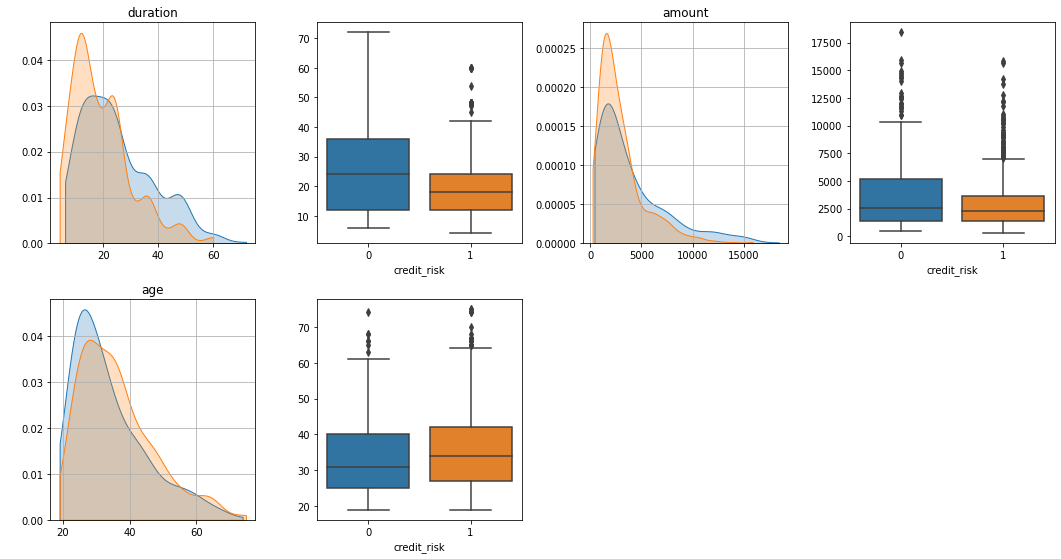

In [8]:
plt.figure(figsize=(18, 60))

for i, col in enumerate(numerical_features):
    plt.subplot(12, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)

    plt.grid(True)
    plt.title(col)
    plt.ylabel(" ")
    plt.xlabel(" ")
    sns.kdeplot(sgc.loc[sgc["credit_risk"]==0, col], label="bad", color = color_0, shade=True, cut=0)
    sns.kdeplot(sgc.loc[sgc["credit_risk"]==1, col], label="good",  color = color_1, shade=True, cut=0)
    plt.subplot(12, 4, i*2+2) 
    sns.boxplot(y = col, data = sgc, x="credit_risk", palette = palette_binary).set(ylabel=" ")
    

Secondly we report the categorical feature.

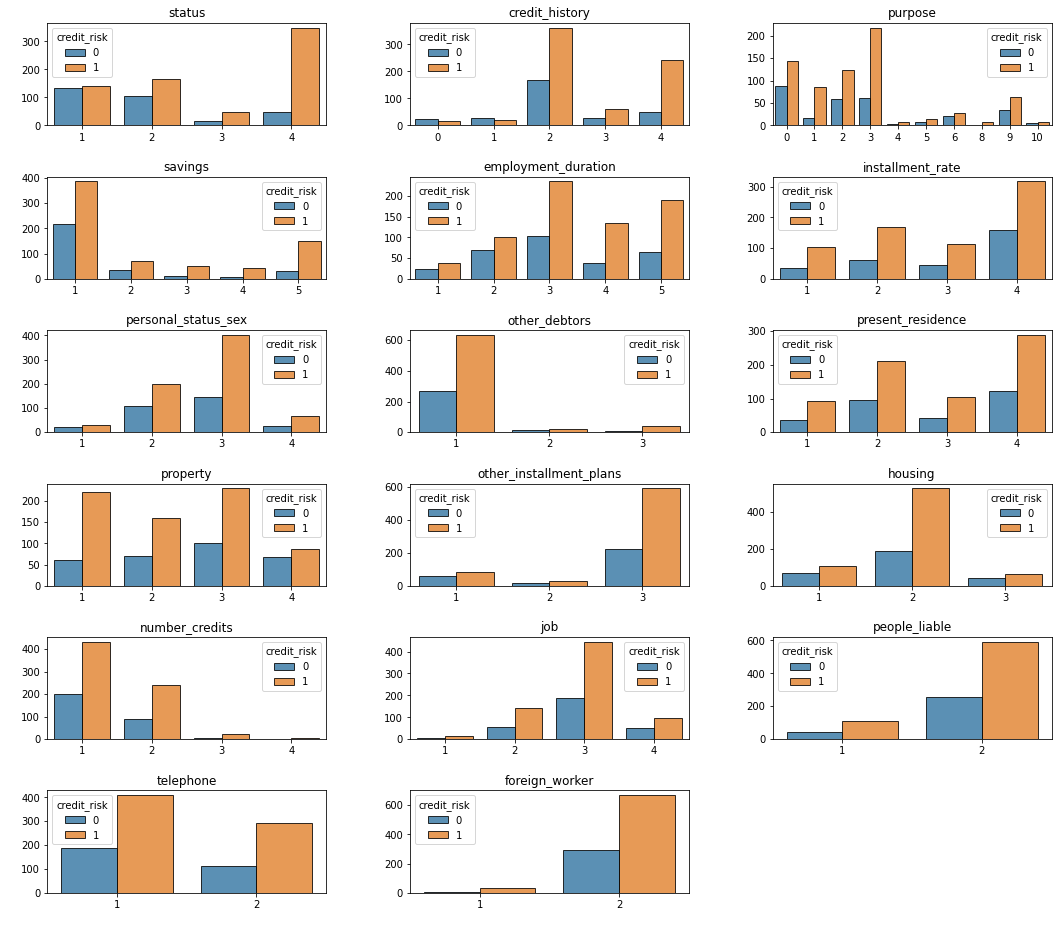

In [9]:
plt.figure(figsize=(18, 16))

for i, col in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=sgc, x=col, hue="credit_risk",
                  palette = palette_binary,
                  alpha=0.8, edgecolor="k", linewidth=1).set(ylabel=" ", xlabel=" ")

## Standardization <a class="anchor" id="std"></a> [△](#ix)

Now is important for numerical features to standardize using `sklearn` function, removing the mean and scaling to unit variance.

$$ {z = \frac{(x−\bar{x})}{\hat{\sigma}}} $$

where ${\bar{x}}$ is the mean of the training samples and $\hat{\sigma}$ is the sample standard deviation.

In [10]:
from sklearn.preprocessing import StandardScaler

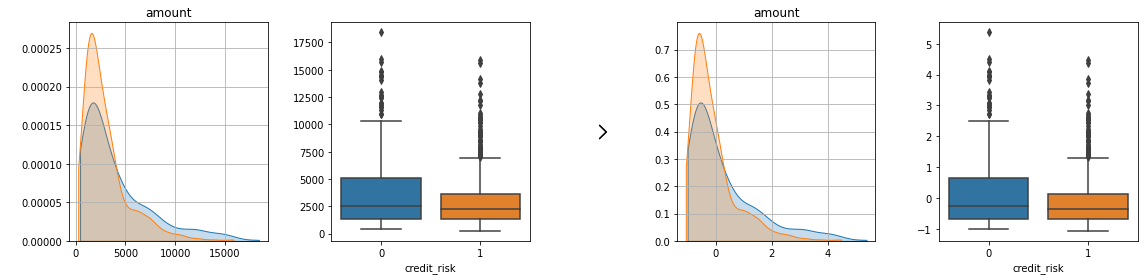

In [11]:
import matplotlib.image as mpimg
from matplotlib import gridspec

sgc_norm = sgc.copy()

for i, col in enumerate(numerical_features):
    sgc_norm[[col]] = StandardScaler(with_mean=True, with_std=True).fit_transform(sgc_norm[[col]])
    
plt.figure(figsize=(16, 4))
gs  = gridspec.GridSpec(1, 5, width_ratios=[1, 1 ,0.1, 1, 1])
plt.subplot(gs[0])   
plt.grid(True)
plt.title("amount")
plt.ylabel(" ")
plt.xlabel(" ")
sns.kdeplot(sgc.loc[sgc["credit_risk"]==0, "amount"], label="bad", color = color_0, shade=True, cut=0)
sns.kdeplot(sgc.loc[sgc["credit_risk"]==1, "amount"], label="good",  color = color_1, shade=True, cut=0)
plt.subplot(gs[1]) 
sns.boxplot(y = "amount", data = sgc, x="credit_risk", palette = palette_binary).set(ylabel=" ");  
plt.subplot(gs[2])
plt.imshow(mpimg.imread("right_arrow.png"))
plt.axis('off')
plt.subplot(gs[3])
plt.grid(True)
plt.title("amount")
plt.ylabel(" ")
plt.xlabel(" ")
sns.kdeplot(sgc_norm.loc[sgc["credit_risk"]==0, "amount"], label="bad", color = color_0, shade=True, cut=0)
sns.kdeplot(sgc_norm.loc[sgc["credit_risk"]==1, "amount"], label="good",  color = color_1, shade=True, cut=0)
plt.subplot(gs[4])
sns.boxplot(y = "amount", data = sgc_norm, x="credit_risk", palette = palette_binary).set(ylabel=" ");  
plt.tight_layout()

## Correlation matrix <a class="anchor" id="cmx"></a> [△](#ix)

To analyze the corrrelation of features a good way is the correlation matrix that is a matrix in which are showed the correlation values of each couple of features according to the <b>Pearson's correlation coefficient</b>:

$${\rho _{X_1,X_2}={\frac {\operatorname {cov} (X_1,X_2)}{\sigma _{X_1}\sigma _{X_2}}}}$$
    
Where cov stands for the covariance measure:

$${\displaystyle \operatorname {cov} (X_1,X_2)=\operatorname {E}{{\big [}(X_1-\operatorname {E} [X_1])(X_2-\operatorname {E} [X_2]){\big ]}},}$$
    
computed for every pair of features ${X_1}$ and ${X_2}$

In [12]:
all_features = categorical_features.copy()
all_features.extend(numerical_features)

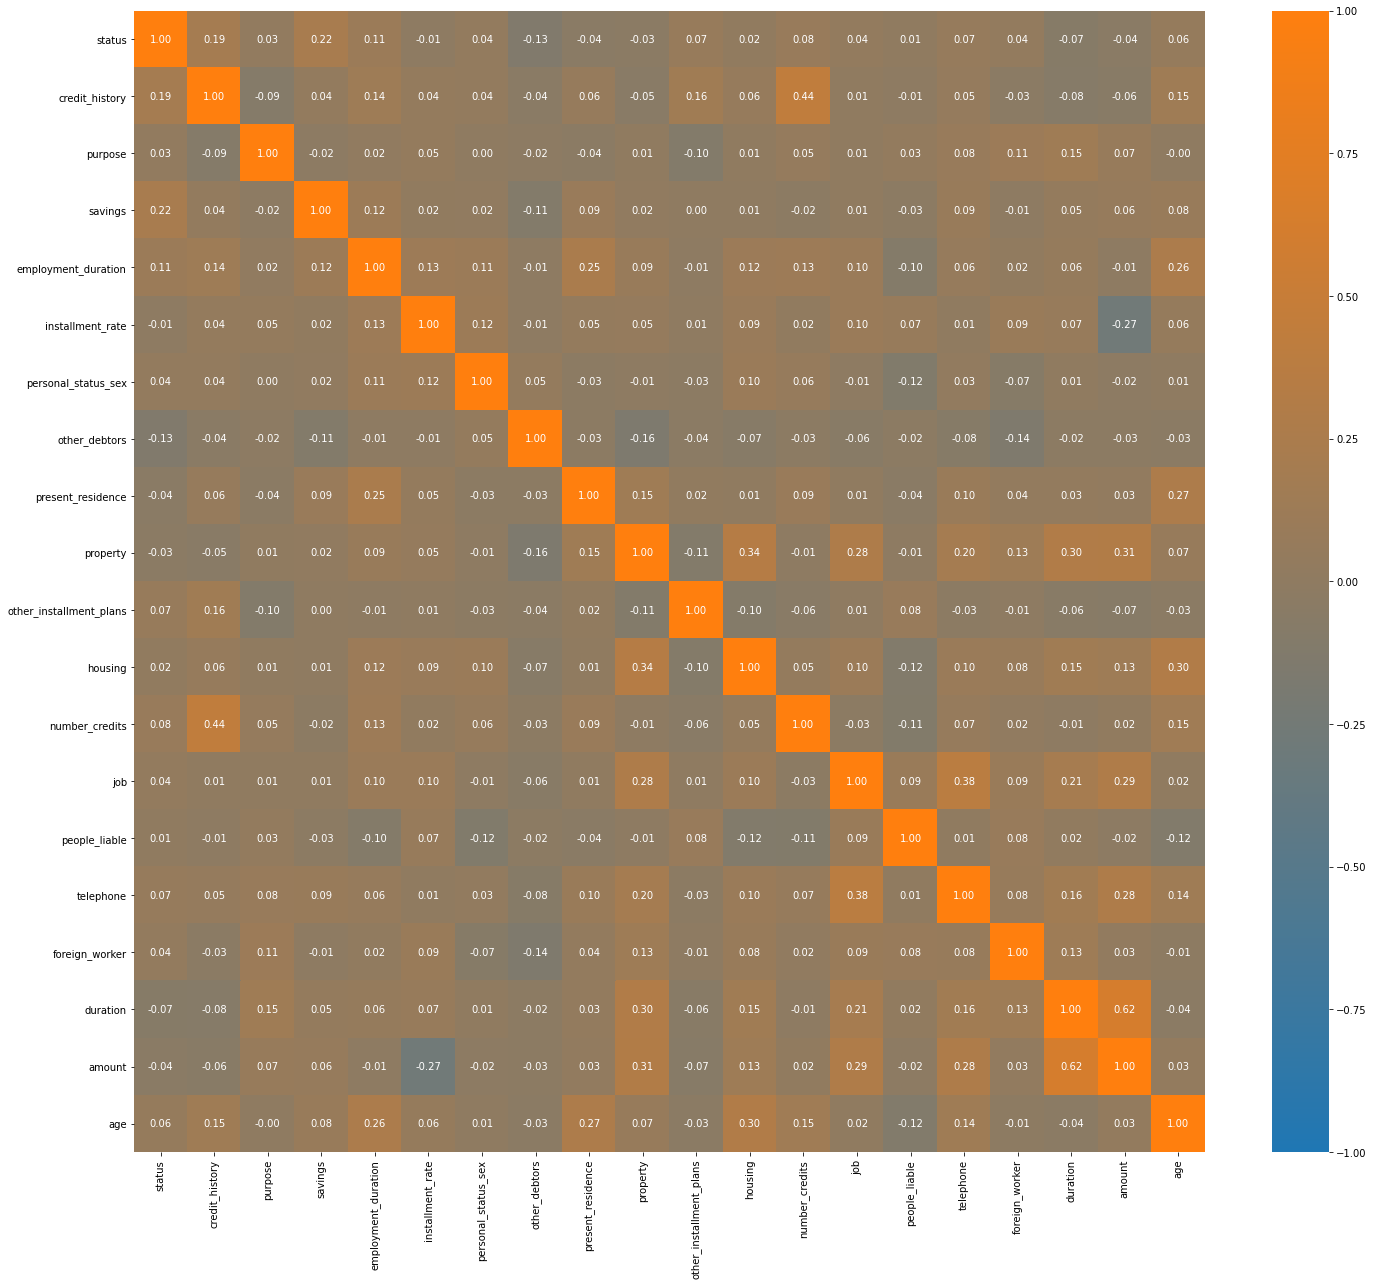

In [13]:
plt.figure(figsize=(24, 21))
sns.heatmap(sgc_norm[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap=cmap_selected, annot=True, fmt='.2f');


From the heatmap we can see that in general, features are quite uncorrelated with few exceptions: in particular `amount` and `duration` that seems to be  quite positively correlated.
As we will see during feature selection, this is not a significant problem since an appropriate choice of features will be performed.

## Validation <a class="anchor" id="vld"></a> [△](#ix)

To validate and test our models we can have two general approaches.<br>
The first one is <b>Holdout</b>, that consists in dividing the dataset into subsets dedicated to training, validation and test. <br>
The second approach is <b>K-Fold</b> that consists in diving the dataset into K parts with an equal number of samples, using K-1 for training and the last one as validation.
This is done K times and each part is used as validation exactly once.
Then the results are combined (averaged).<br>

<img style="float: left; margin-left:-12px;" src="https://miro.medium.com/max/4788/1*Rpz58-KQdziQ-YXtpL1Kvg.png" width="500" height="500">

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [15]:
train_ratio = 0.70
val_ratio = 0.30

ho_train_sgc, ho_val_sgc = train_test_split(sgc_norm, train_size = train_ratio, random_state=42)
unnorm_ho_train_sgc, unnorm_ho_val_sgc = train_test_split(sgc, train_size = train_ratio, random_state=42)

print("Holdout split:")
print(f"Train samples: {len(ho_train_sgc)}")
print(f"Validation/Test samples: {len(ho_val_sgc)}")

Holdout split:
Train samples: 700
Validation/Test samples: 300


## Feature selection <a class="anchor" id="fsl"></a> [△](#ix)

### Mutual information <a class="anchor" id="mi"></a> [△](#ix)

Mutual information can be useful to analyze the dependence of a feature with respect to the target.
MI is always > 0 and higher values indicate stronger dependence.
Below there is the formal definition for the discrete case<br>

\begin{align} {I(X;Y) =\sum_{y \in Y}\sum_{x \in X}p_{X, Y}(x, y)log\Bigg( \frac {p_{X, Y}(x, y)}{p_X(x)p_Y(y)} \Bigg)} \end{align}

In this case the mutual information is estimated for each feature with respect to the class label `credit_risk`.
Mutual information is estimated with the function mutual_info_classif from `sklearn` (exploits entropy estimation from k-nearest neighbors distances).

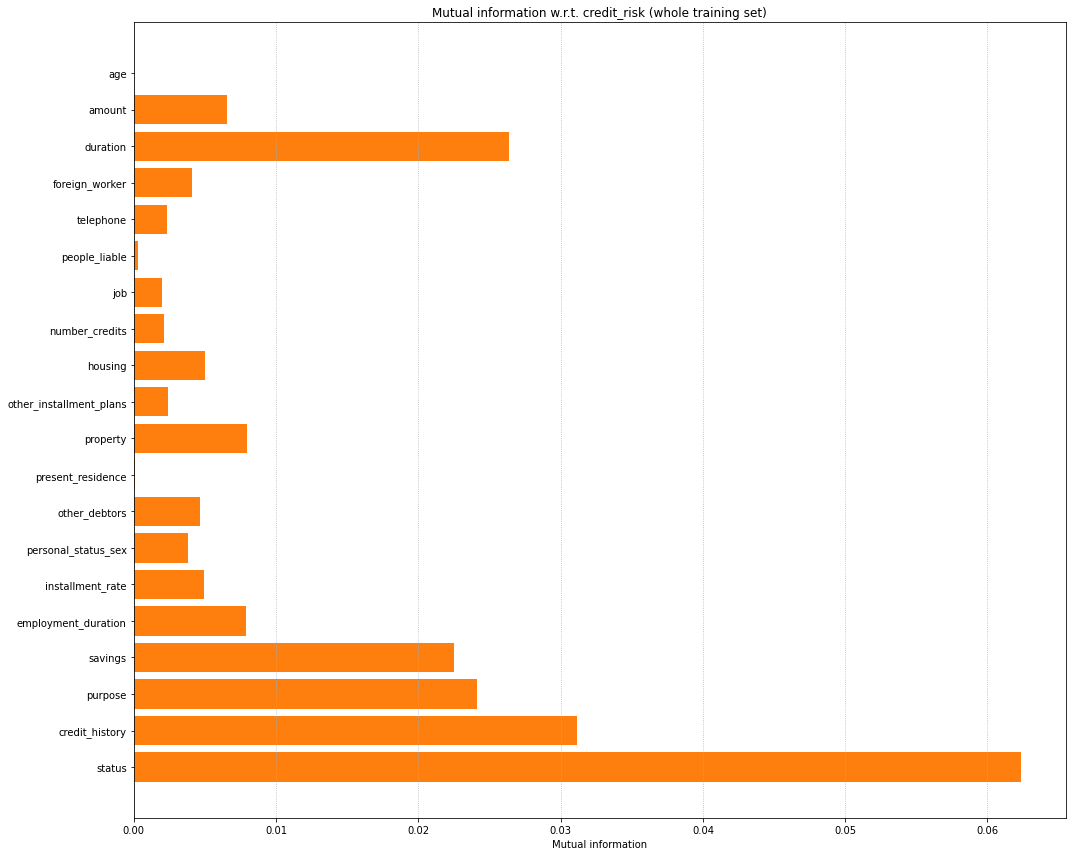

In [16]:
from sklearn.feature_selection import mutual_info_classif

MI = (mutual_info_classif(ho_train_sgc[all_features],
                             ho_train_sgc["credit_risk"], n_neighbors=20,
                             discrete_features=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,
                                                False,False,False],
                             random_state=42))

plt.figure(figsize=(15, 12))
plt.barh(y=all_features, width=MI, color=color_1)
plt.title("Mutual information w.r.t. credit_risk (whole training set)");
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':');
plt.tight_layout();


### Chi-squared test <a class="anchor" id="cs"></a> [△](#ix)

For the categorical features we can also use <b>chi-squared test</b>.<br>
A lower value of the statistic means a stronger independence.

Chi-squared test is performed starting from the contingency table, for instance:

In [17]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

print("Observed")
ctable = pd.crosstab(ho_train_sgc["people_liable"], ho_train_sgc["credit_risk"])
ctable.columns = ["0=Bad", "1=Good"]
ctable.index = ["people_liable=0", "people_liable=1"]
ctable.loc["Total"] = ctable.sum()
ctable["Total"] = ctable.sum(axis=1)
ctable

Observed


0=Bad  1=Good  Total
people_liable=0     28      75    103
people_liable=1    180     417    597
Total              208     492    700

that indicates how samples are distributed among these two features.

The null hypothesis is that people_liable and credit_risk are independent, so we compute the expected values considering them as under the null hypothesis, so:
<br><br>
<left> $ P(people\_liable=0,credit\_risk=0)=P(people\_liable=0)×P(credit\_risk=0)=\frac{115×225}{750×750}=0.046 $ </left>
<left> $ E(people\_liable=0,credit\_risk=0)=P(people\_liable=0)×P(credit\_risk=0)× N=0.046×750=34.5 $ </left>

In [18]:
print("Expected")
contingency_table = pd.crosstab(ho_train_sgc["people_liable"], ho_train_sgc["credit_risk"])
stat, p, dof, expected = chi2_contingency(contingency_table)
expected = pd.DataFrame(expected)
expected.columns = ["0=Bad", "1=Good"]
expected.index = ["people_liable=0", "people_liable=1"]
expected

Expected


0=Bad      1=Good
people_liable=0   30.605714   72.394286
people_liable=1  177.394286  419.605714

We know that:

\begin{align} {X^2 = \sum_{i=1}^k \frac{(o_i - e_i)^2}{e_i}} \end{align}

where $o_i$ is the observed value and $e_i$ is the expected value of the i-th combination of features.
As the number of samples goes to infinity, $X^2$ tends to a $\chi^2$ distribution with (columns-1)*(rows-1) degrees of freedom (so in this case 1).

In the scipy implementation, the statistic is further corrected with <b>Yates correction</b> for continuity that, according to the documentation (and definition), consists in subtracting 0.5 from the absolute difference, in the numerator.

Now that we have the statistic we could compare it with a <b>chi2 distribution</b> with those given degrees of freedom, keeping only the features that produce an high p-value (not rejected).

In [19]:
def chi2_test(df, feat1, feat2):

    contingency_table = pd.crosstab(df[feat1], df[feat2])
    
    stat, p, dof, expected = chi2_contingency(contingency_table)
    prob = 0.95 # alpha=0.05
    critical = chi2.ppf(prob, dof)
    #print('alpha=%.3f, p=%.3f, critical_value=%.3f,\nstat=%.3f' % (1 - prob, p, critical, stat))

    alpha = 1.0 - prob
    
    return stat, p

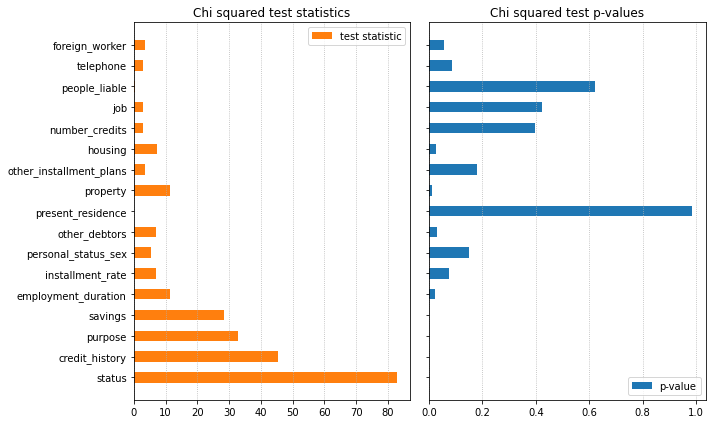

In [20]:
stats = []
p_values = []

for feat in categorical_features:
    
    stat, p = chi2_test(ho_train_sgc, feat, "credit_risk")
    stats.append(stat)
    p_values.append(p)        

fig, axes = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(10, 6)
axes[0].barh(y=categorical_features, width=stats, color=color_1, label="test statistic", height=0.5)
axes[0].set_title("Chi squared test statistics")

axes[1].barh(y=categorical_features, width=p_values, color=color_0, label="p-value", height=0.5)
axes[1].set_title("Chi squared test p-values")

axes[0].xaxis.grid(True, linestyle=':');
axes[1].xaxis.grid(True, linestyle=':');

axes[0].legend(loc=1)
axes[1].legend(loc=4)

fig.subplots_adjust(wspace=0.06)
plt.tight_layout()

Considering these results and the analysis of the correlation matrix, we decided to select a mix of categorical and numerical features.

Categorical: `present_residence`, `number_credits`, `job`, `people_liable`<br>
Numerical: `age`, `amount`

This selection is intended for the hold out case. Finally, we perform a final check on the correlation matrix which gives acceptable results.

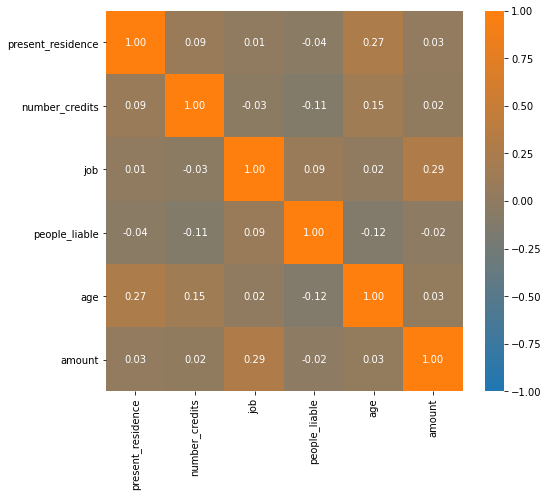

In [21]:
numerical_features_selected = ["age", "amount"]
categorical_features_selected = ["present_residence", "number_credits", "job", "people_liable"]

all_features_selected = categorical_features_selected.copy()
all_features_selected.extend(numerical_features_selected)

plt.figure(figsize=(8, 7))
sns.heatmap(sgc_norm[all_features_selected].corr(method='pearson'), vmin=-1, vmax=1, cmap=cmap_selected, annot=True, fmt='.2f');


### KFold features selection <a class="anchor" id="kfs"></a> [△](#ix)

In general when kfold crossvalidation is done, feature selection needs to be performed inside every iteration to avoid an overestimation of the accuracy.<br>

In [22]:
kfold_train_sgc, kfold_val_sgc = ho_train_sgc.copy(), ho_val_sgc.copy()

Mutual information with respect to credit_risk (5 folds)


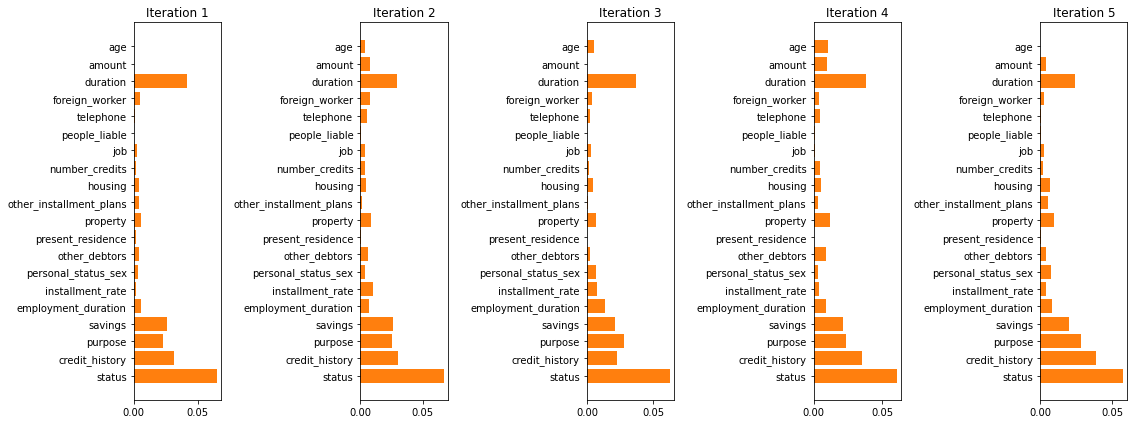

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(16, 6))

print("Mutual information with respect to credit_risk (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_sgc, kfold_train_sgc["credit_risk"])):
    MI=(mutual_info_classif(kfold_train_sgc.iloc[train_idx][all_features],
                             kfold_train_sgc.iloc[train_idx]["credit_risk"], n_neighbors=20,
                             discrete_features=[True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,
                                                False,False,False],
                             random_state=42))
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=all_features, width=MI, color=color_1, label="test statistic")
    
plt.tight_layout()  

The situation for mutual information does not change: the most relevant features on average are the same as in the hold out case.

Chi squared test statistics (5 folds)


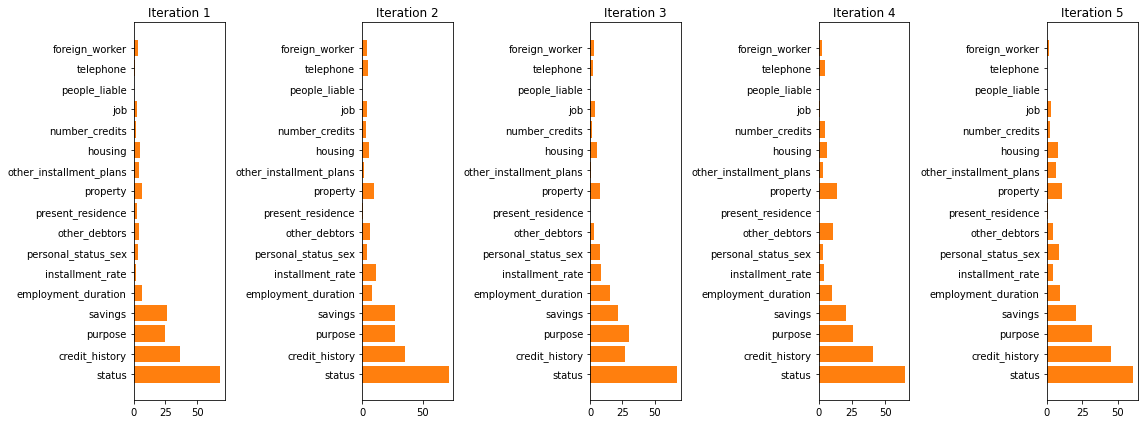

In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(16, 6))
print("Chi squared test statistics (5 folds)")
for i, (train_idx, val_idx) in enumerate(kf.split(kfold_train_sgc, kfold_train_sgc["credit_risk"])):
    stats = []
    p_values = []

    for feat in categorical_features:

        stat, p = chi2_test(kfold_train_sgc.iloc[train_idx], feat, "credit_risk")
        stats.append(stat)
        p_values.append(p)
    
    plt.subplot(1, 5, i+1)
    plt.title(f"Iteration {i+1}")
    plt.barh(y=categorical_features, width=stats, color=color_1, label="test statistic")
plt.tight_layout()

Also the situation for Chi squared test does not change. The selection made for the hold out case can also be valid for kfold crossvalidation.

In [25]:
all_features_selected_kfold = []
for i in range (5):
    all_features_selected_kfold.insert(0,all_features_selected)

## Class imbalance <a class="anchor" id="cli"></a> [△](#ix)

The class imbalance is a factor to be taken into account.

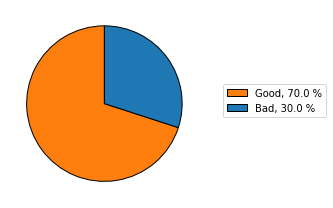

In [26]:
class_labels = ["Good", "Bad"]
sizes = [x / len(sgc["credit_risk"]) * 100 for x in sgc["credit_risk"].value_counts().tolist()]
final_labels = ["%s, %1.1f %%" % (l, s) for l, s in zip(class_labels, sizes)]

plt.pie(sgc["credit_risk"].value_counts(),
        colors = [color_1, color_0], 
        wedgeprops={'edgecolor':'black', 'linewidth': 1}, 
        startangle=90);

plt.legend(final_labels, bbox_to_anchor=(0.75,0.5), loc="center right", 
                          bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)


This imbalance can leads to biased results that can be noticed by measures such as precision, recall or f1.
To handle class inbalance it is possible to re-balance the dataset with different techniques.

### Random oversampling <a class="anchor" id="rs"></a> [△](#ix)

Random oversampling is a resample technique that consists in take randomly samples from the minority class and adding them to dataset. During training, random oversampling needs to be done after the subdivision into train, validation and test to avoid data leakage.<br>
The idea is that, not being able to sample more samples from the true distribution, we sample them from the empirical distribution coming from the samples that we already have.

In [27]:
n_to_sample = len(ho_train_sgc[ho_train_sgc.credit_risk==1]) - len(ho_train_sgc[ho_train_sgc.credit_risk==0])
new_samples = ho_train_sgc[ho_train_sgc.credit_risk==0].sample(n_to_sample, replace=True, random_state=42)

ho_train_sgc_rs = ho_train_sgc.append(new_samples)

new_samples = unnorm_ho_train_sgc[unnorm_ho_train_sgc.credit_risk==0].sample(n_to_sample, replace=True, random_state=42)
unnorm_ho_train_sgc_rs = unnorm_ho_train_sgc.append(new_samples)

Here we can see the distribution of `amount` for only minority class samples before and after oversampling. (the line is a kde)

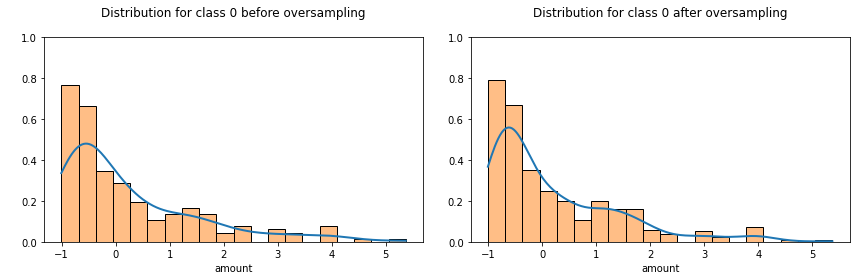

In [28]:
nbins = 20
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.ylim(0, 1)
plt.ylabel(" ")
plt.title("Distribution for class 0 before oversampling\n")
hist1 = sns.histplot(ho_train_sgc[ho_train_sgc.credit_risk==0].amount, bins=nbins, stat="density", color=color_1, kde=True, line_kws={'lw':2});
hist1.get_lines()[0].set_c(color_0)

plt.subplot(1, 2, 2)
plt.ylim(0, 1)
plt.ylabel(" ")
plt.title("Distribution for class 0 after oversampling\n")
hist2 = sns.histplot(ho_train_sgc_rs[ho_train_sgc_rs.credit_risk==0].amount, bins=nbins, stat="density",  color=color_1, kde=True, line_kws={ 'lw':2});
hist2.get_lines()[0].set_c(color_0)

plt.tight_layout()


### SMOTE <a class="anchor" id="sm"></a> [△](#ix)

Synthetic Minority Oversampling Technique or SMOTE is a useful technique used to deal with unbalanced datasets. It consists in taking for each sample of the minority class the k-nearest neighbours an then generate new samples starting from the sample and one of the nearest neighbours (chosen randomly).

To show how SMOTE works let's plot the samples according to `amount` and `age`. In the visualization below, SMOTE is performed on the whole dataset while then, when we use it during classification, we perform it only on training samples.
The same happens in the kfold case in which resampling methods are applied inside each iteration and not before.

A jittering is added on the x axis to better perform visualization of the distribution.

In [29]:
def rand_jitter(arr):
    np.random.seed(42)
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [30]:
norm = np.linalg.norm
import random
from random import sample 

def SMOTE(data, sampling_rate, n_neigh, random_state=42):
    random.seed(random_state)
    new_samples = []
    
    if sampling_rate==0:
        return
    
    if sampling_rate>n_neigh: return      
    data = data.reset_index(drop=True)

    n_samples = data.count()[0]

    for i in range(n_samples):
        dists = []
        for j in range(n_samples):
            if i==j: continue
            dists.append((j, norm(data.loc[i]-data.loc[j])))    
        
        topk = sorted(dists, key=lambda s: s[1])[:n_neigh]
        neighs = sample(topk, sampling_rate)

        for neigh in neighs:
            alpha = random.random()
            new_samples.append(data.loc[i] + alpha * (data.loc[neigh[0]]-data.loc[i]))
            
    return new_samples

In [31]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

In [32]:
fig.set_size_inches(4, 4);
fig.set_dpi(100)

def animate_func(i):
    new_samples = SMOTE(sgc[sgc["credit_risk"]==0][["amount", "age"]], sampling_rate = i, n_neigh = 5)
    sm_sgc = sgc.copy()

    if new_samples:
        sm_sgc = sgc.append(new_samples)
        
    sm_sgc["credit_risk"].fillna(0, inplace=True)
    
    ax.clear();

    
    ax.scatter((sm_sgc[sm_sgc["credit_risk"]==1]["amount"]),
            sm_sgc[sm_sgc["credit_risk"]==1]["age"], s=2, label="Good", color=color_1, alpha=1)
    ax.scatter(rand_jitter(sm_sgc[sm_sgc["credit_risk"]==0]["amount"]),
            sm_sgc[sm_sgc["credit_risk"]==0]["age"], s=2, label="Bad", color=color_0, alpha=1)
    ax.legend()
    
    ax.set_xlabel("amount")
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("age")
    ax.set_title(f"Sampling rate: {i}, Bad = {sm_sgc[sm_sgc.credit_risk==0].count()['age']}, Good = {sm_sgc[sm_sgc.credit_risk==1].count()['age']}")

    return [fig]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 3,
                               interval = 100, # in ms
                               );

HTML(anim.to_jshtml())

This implementation of SMOTE is based on the original paper by N. V. Chawla et al. [[3](#r3)].

In this case with a sample rate of 1 we obtain a quite good balance between classes.

In [33]:
new_samples = SMOTE(ho_train_sgc[ho_train_sgc["credit_risk"]==0][all_features_selected],
                    sampling_rate = 1, n_neigh = 20)

# categorical attributes need to be fixed
for s in new_samples:
    s["present_residence"] = np.round(s["present_residence"])
    s["number_credits"] = np.round(s["number_credits"])
    s["job"] = np.round(s["job"])
    s["people_liable"] = np.round(s["people_liable"])

ho_train_sgc_sm = ho_train_sgc.append(new_samples)
ho_train_sgc_sm["credit_risk"].fillna(0, inplace=True)


new_samples = SMOTE(unnorm_ho_train_sgc[unnorm_ho_train_sgc["credit_risk"]==0][all_features_selected],
                    sampling_rate = 1, n_neigh = 20)

# categorical attributes need to be fixed
for s in new_samples:
    s["present_residence"] = np.round(s["present_residence"])
    s["number_credits"] = np.round(s["number_credits"])
    s["job"] = np.round(s["job"])
    s["people_liable"] = np.round(s["people_liable"])

unnorm_ho_train_sgc_sm = unnorm_ho_train_sgc.append(new_samples)
unnorm_ho_train_sgc_sm["credit_risk"].fillna(0, inplace=True)

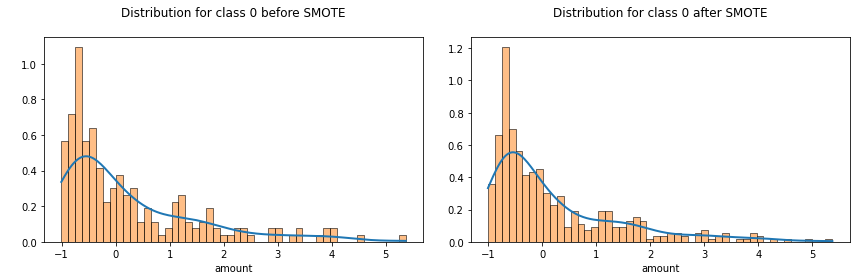

In [34]:
nbins = 50
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)

plt.ylabel(" ")
plt.title("Distribution for class 0 before SMOTE\n")
hist1 = sns.histplot(ho_train_sgc[ho_train_sgc.credit_risk==0].amount, bins=nbins, stat="density", color=color_1, kde=True, line_kws={'lw':2});
hist1.get_lines()[0].set_c(color_0)

plt.subplot(1, 2, 2)

plt.ylabel(" ")
plt.title("Distribution for class 0 after SMOTE\n")
hist2 = sns.histplot(ho_train_sgc_sm[ho_train_sgc_sm.credit_risk==0].amount, bins=nbins, stat="density",  color=color_1, kde=True, line_kws={ 'lw':2});
hist2.get_lines()[0].set_c(color_0)

plt.tight_layout()

### Class-weight parameter <a class="anchor" id="cw"></a> [△](#ix)

Another way to handle the class imbalance is class weighting.
Many models present this parameter that allows to weight samples during training according to the imbalance.
The configuration tested is `class-weight="balanced"` that according to the `sklearn` documentation sets the weights in this way:

$$ w_{i}=N_{m}×n_{i} $$ 
<br>where $N$ is the total number of samples, $m$ is the number of classes and $n_{i}$ is the number of samples belonging to class $i$.

In our case the weights will be:

In [35]:
w = len(ho_train_sgc) / (2 * np.bincount(ho_train_sgc.credit_risk))
print(f"Bad  -> 0: {w[0]} \nGood -> 1: {w[1]}")

Bad  -> 0: 1.6826923076923077 
Good -> 1: 0.7113821138211383


In [36]:
# KFOLD

class KFold():
    
    # caching smote results 
    smote_folds = None
    smote_labels = None
    
    def __init__(self, all_features_kfold, random_state=42):
        self.smote_folds = []
        self.smote_labels = []
        self.features = all_features_kfold
        
        self.kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    def fit_predict(self, model, X, y, threshold = None, resampling = None, cached = False):
        acc, rec, pre, f1 = 0, 0, 0, 0
        
        if resampling=="SMOTE" and not cached:
            self.smote_folds = []
            self.smote_labels = []
        
        for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
           
            X_fold = X[self.features[0]] # in this case same features for each fold
        
            X_train, X_val = X_fold.iloc[train_idx], X_fold.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if resampling=="oversampling":
                n_to_sample = len(X_train[y_train==1]) - len(X_train[y_train==0])
                new_samples = X_train[y_train==0].sample(n_to_sample, replace=True, random_state=42)
                
                X_train = X_train.append(new_samples)
                y_train = y_train.append(pd.Series([0]*len(new_samples)))
                
                X_train = X_train.reset_index(drop=True)
                y_train = y_train.reset_index(drop=True)
                
            if resampling=="SMOTE": 
                if not cached or len(self.smote_folds)<5 or len(self.smote_labels)<5:
                    n_to_sample = len(X_train[y_train==1]) - len(X_train[y_train==0])
                    new_samples = SMOTE(X_train[y_train==0], sampling_rate = 1, n_neigh = 20)

                    # categorical attributes need to be fixed
                    for s in new_samples:
                        s["present_residence"] = np.round(s["present_residence"])
                        s["number_credits"] = np.round(s["number_credits"])
                        s["job"] = np.round(s["job"])
                        s["people_liable"] = np.round(s["people_liable"])

                    X_train = X_train.append(new_samples, ignore_index=True)
                    y_train = y_train.append(pd.Series([0]*len(new_samples)))
                    
                    X_train = X_train.reset_index(drop=True)
                    y_train = y_train.reset_index(drop=True)
                    
                    # cache smoted folds
                    self.smote_folds.append(X_train)
                    self.smote_labels.append(y_train)
                    
                else:
                    # use cached folds
                    X_train = self.smote_folds[i]
                    y_train = self.smote_labels[i]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            if threshold:
                preds[preds>=threshold] = 1
                preds[preds<threshold] = 0

            acc += accuracy_score(y_val, preds)
            pre += precision_score(y_val, preds)
            rec += recall_score(y_val, preds)
            f1 += f1_score(y_val, preds)

        acc /= 5
        pre /= 5
        rec /= 5
        f1 /= 5
        return acc, pre, rec, f1

In [37]:
kfold = KFold(all_features_selected_kfold, random_state=42)

# Classifiers <a class="anchor" id="cls"></a> [△](#ix2)

## Metrics <a class="anchor" id="mtr"></a> [△](#ix2)

All models are evaluated considering the following metrics

${accuracy = \frac {TP+TN}{TP+TN+FP+FN}\quad }$
${precision = \frac {TP}{TP+FP}\quad}$
${recall = \frac {TP}{TP+FN}\quad}$
${F_1 = 2 \times \frac{precision \times recall}{precision+recall}}$


Moreover, ROC curve is also evaluated:
<b>Receiver Operating Characteristic</b> is a plot that shows the True Positive and False positive rates applying different thresholds on the prediction (that needs to be a number between 0 and 1).<br>
Then, model selection can be also performed according to the Area Under the Curve (<b>AUC</b>) that is the area under the roc curve. (the higher the better)



In [38]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

In [39]:
final_results = pd.DataFrame(columns=["Model", "Holdout Original","Holdout Oversampling", "Holdout Undersampling", "Holdout SMOTE", 
                   "Holdout class-weight=balanced", "KFold Original", "KFold Oversampling", "KFold Undersampling",
                   "KFold SMOTE", "KFold class-weight=balanced"])

## Decision tree <a class="anchor" id="dtr"></a> [△](#ix2)

Decision trees are famous non-parametric models that learn by recursively split the predictor space (and so the train samples) according to the best feature (<b>greedy approach</b>) until the tree reaches a constrained depth, the subsets contain elements of only one class or it meets another stopping criterion (e.g. less than 10 samples in the subset).<br>
The best feature is the feature that, if used to discriminate samples, allows us to obtain the best possible split according to a measure. Such measure in this case is the <b>Gini Index</b> (using `sklearn` implementation the unnormalized gini index is considered)

$$ {G = 1-\sum_{j} p_j^2} $$
where $p$ is the ratio between number of samples of class $j$ and total number of samples.

Gini index is evaluated on both the splits, weighted by the number of samples in each split and the feature that gives us the lower overall Gini index is chosen.

The explainability of this model is quite high. In fact is possible to plot the tree to see how the dataset is split at every step and it's easy to describe how the prediction works.
The main drawback of decision tree is the fact that sometimes is a too simple model, that provides lower values of accuracy and it's easy to overfit.
To tackle this problem it's possible to train an ensemble of decision trees, called random forest.

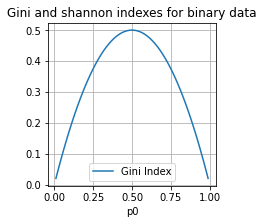

In [40]:
p = np.linspace(1e-2, 1-1e-2, 100)

plt.figure(figsize=(3, 3))
plt.plot(p, [1-pj**2-(1-pj)**2 for pj in p], label="Gini Index", color=color_0)
plt.grid()
plt.legend();
plt.xlabel("p0")
plt.title("Gini and shannon indexes for binary data");

This is an example of how a two feature decisison tree work.

In [41]:
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

depth = range(1, 6)
h = 0.03
x_min, x_max = sgc["people_liable"].min() - 1, sgc["people_liable"].max() + 1
y_min, y_max = sgc["amount"].min() - .5, sgc["amount"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

fig.set_size_inches(14, 7);
def animate_func(i):
    
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth[i], random_state=42, )
    dt.fit(sgc[["people_liable", "amount"]], sgc.credit_risk)
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.3, colors=[color_0, color_0, color_1, color_1])
    ax1.scatter(sgc[sgc["credit_risk"]==0]["people_liable"],
                sgc[sgc["credit_risk"]==0]["amount"], label="Bad", color=color_0, edgecolor='BLACK')
    ax1.scatter(sgc[sgc["credit_risk"]==1]["people_liable"],
                sgc[sgc["credit_risk"]==1]["amount"], label="Good", color=color_1, edgecolor='BLACK')

    ax1.set_xlabel("people_liable")
    ax1.set_ylabel("amount")
    ax1.legend();

    graph = tree.plot_tree(dt,  feature_names=["people_liable", "amount"], filled=True,
                   label='none', ax=ax2, rounded=True, proportion=True, impurity=False );
    
    
    ax2.set_title(f"Decision tree (depth: {i+1})")
    
    fig.tight_layout()
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(depth),
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())

We can train decision trees considering the original dataset and rebalanced ones. Another model can be trained with `class_weight="balanced"`. 
For decision trees and random forests, normalization is not necessary, so for the sake of visualization we use the unnormalized features.

In [42]:
depth = range(1, 20)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_sgc[all_features_selected], unnorm_ho_train_sgc['credit_risk'])
    pred = dt.predict(unnorm_ho_val_sgc[all_features_selected])
    no_rs_acc.append(accuracy_score(unnorm_ho_val_sgc["credit_risk"], pred))
    no_rs_rec.append(recall_score(unnorm_ho_val_sgc["credit_risk"], pred))
    no_rs_pre.append(precision_score(unnorm_ho_val_sgc["credit_risk"], pred))
    no_rs_f1.append(f1_score(unnorm_ho_val_sgc["credit_risk"], pred))
    
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_sgc_rs[all_features_selected], unnorm_ho_train_sgc_rs['credit_risk'])
    pred = dt.predict(unnorm_ho_val_sgc[all_features_selected])
    rs_acc.append(accuracy_score(unnorm_ho_val_sgc["credit_risk"], pred))
    rs_rec.append(recall_score(unnorm_ho_val_sgc["credit_risk"], pred))
    rs_pre.append(precision_score(unnorm_ho_val_sgc["credit_risk"], pred))
    rs_f1.append(f1_score(unnorm_ho_val_sgc["credit_risk"], pred))
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_sgc_sm[all_features_selected], unnorm_ho_train_sgc_sm['credit_risk'])
    pred = dt.predict(unnorm_ho_val_sgc[all_features_selected])
    sm_acc.append(accuracy_score(unnorm_ho_val_sgc["credit_risk"], pred))
    sm_rec.append(recall_score(unnorm_ho_val_sgc["credit_risk"], pred))
    sm_pre.append(precision_score(unnorm_ho_val_sgc["credit_risk"], pred))
    sm_f1.append(f1_score(unnorm_ho_val_sgc["credit_risk"], pred))
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    dt.fit(unnorm_ho_train_sgc[all_features_selected], unnorm_ho_train_sgc['credit_risk'])
    pred = dt.predict(unnorm_ho_val_sgc[all_features_selected])
    w_acc.append(accuracy_score(unnorm_ho_val_sgc["credit_risk"], pred))
    w_rec.append(recall_score(unnorm_ho_val_sgc["credit_risk"], pred))
    w_pre.append(precision_score(unnorm_ho_val_sgc["credit_risk"], pred))
    w_f1.append(f1_score(unnorm_ho_val_sgc["credit_risk"], pred))

#print(np.mean(no_rs_acc), np.mean(rs_acc), np.mean(sm_acc),np.mean(w_acc))
#print(np.mean(no_rs_f1), np.mean(rs_f1), np.mean(sm_f1), np.mean(w_f1))


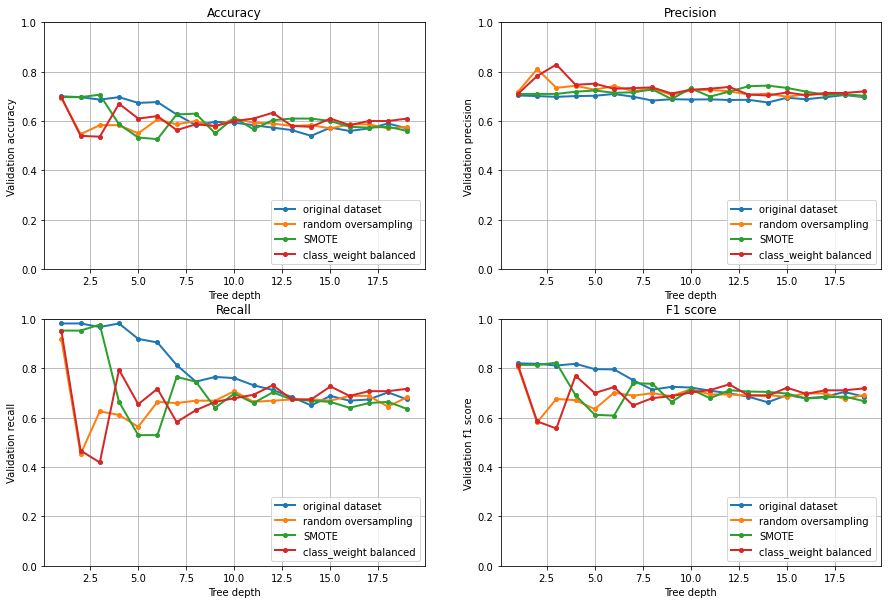

In [43]:
plt.figure(figsize=(15, 10))

# accuracy
plt.subplot(2, 2, 1) 
plt.plot(list(depth), no_rs_acc, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), rs_acc, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_acc, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_acc, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("Tree depth")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)    
plt.plot(list(depth), no_rs_pre, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), rs_pre, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_pre, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_pre, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("Tree depth")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3) 
plt.plot(list(depth), no_rs_rec, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), rs_rec, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_rec, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_rec, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("Tree depth")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(depth), no_rs_f1, label = "original dataset", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), rs_f1, label="random oversampling", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), sm_f1, label="SMOTE", marker='o', linewidth=2, markersize=4)
plt.plot(list(depth), w_f1, label = "class_weight balanced", marker='o', linewidth=2, markersize=4)

plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("Tree depth")
plt.title("F1 score");

Below we can see how the tree grows according to the depth constraint.
Having trained the tree with unnormalized features, from the visualization we can see the split policies on the original feature values, providing so a clearer explaination.

In [44]:
# KFOLD

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
ru_acc, ru_rec, ru_pre, ru_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
w_acc, w_rec, w_pre, w_f1 = [], [], [], []

for d in depth: 
    
    # not resampled
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, pre, rec, f1 = kfold.fit_predict(dt, ho_train_sgc, ho_train_sgc['credit_risk'])
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)
    
    # random oversampling 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, pre, rec, f1 = kfold.fit_predict(dt, ho_train_sgc, ho_train_sgc['credit_risk'],
                                                          resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE 
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight=None)
    acc, pre, rec, f1 = kfold.fit_predict(dt, ho_train_sgc, ho_train_sgc['credit_risk'],
                                                          cached=True, resampling="SMOTE")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
 
    # weighted classes
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d, random_state=42, class_weight='balanced')
    acc, pre, rec, f1 = kfold.fit_predict(dt, ho_train_sgc, ho_train_sgc['credit_risk'])
    w_acc.append(acc)
    w_rec.append(rec)
    w_pre.append(pre)
    w_f1.append(f1)

In [45]:
%matplotlib notebook
plt.ioff()
fig, ax = plt.subplots(1, 1);
%matplotlib inline 
plt.ion()

fig.set_size_inches(20, 15);
def animate_func(i):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i+1, random_state=42, class_weight=None)
    dt.fit(unnorm_ho_train_sgc_sm[all_features_selected], unnorm_ho_train_sgc_sm['credit_risk'])
    pred = dt.predict(unnorm_ho_val_sgc[all_features_selected])
    
    tree.plot_tree(dt,  feature_names=all_features_selected, filled=True, label='all', ax=ax, rounded=True, proportion=True);
    ax.set_title(f"Decision tree (depth: {i+1})", fontsize=25)
    # value are float variables due to class_weight="balanced"
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = 15,
                               interval = 200, # in ms
                               );

HTML(anim.to_jshtml())

## Random forest <a class="anchor" id="rfr"></a> [△](#ix2)

Random forest is an ensemble model based on a number of decision trees.
The decision trees are trained with data, <b>sampled with repetition</b> from the original dataset (named "bagging").
Bootstrapping training data is a good way to decrease the variance of the model without increasing the bias (average of many trees is less sensitive to noise with respect to single tree) and helps us to train trees that are less correlated.
Moreover <b>feature bagging</b> is performed, in fact at each candidate split, only a subset of features is considered ($\sqrt{log_2{N}}$, where $N$ is the total features number).
This forces the models to select different features, increasing uncorrelation.
Prediction is then done by majority voting.

In [93]:
# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
max_features='sqrt' # square root of number of features       
max_depth = 20
depth = range(1, max_depth)
n_trees = [5, 10, 20, 50, 100]
n_vals = len(n_trees)

rs_acc,  rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc,  sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
no_rs_acc,  no_rs_rec, no_rs_pre, no_rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc,  w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], []
    sm_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], []
    no_rs_acc[i], no_rs_rec[i], no_rs_pre[i], no_rs_f1[i] = [], [], [], []
    w_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], []
    
    for d in depth: 
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk']);
        pred = rf.predict(ho_val_sgc[all_features_selected]);
        no_rs_acc[i].append(accuracy_score(ho_val_sgc["credit_risk"], pred))
        no_rs_rec[i].append(recall_score(ho_val_sgc["credit_risk"], pred))
        no_rs_pre[i].append(precision_score(ho_val_sgc["credit_risk"], pred))
        no_rs_f1[i].append(f1_score(ho_val_sgc["credit_risk"], pred))
        
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)
        
        rf.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk']);
        pred = rf.predict(ho_val_sgc[all_features_selected]);
        rs_acc[i].append(accuracy_score(ho_val_sgc["credit_risk"], pred))
        rs_rec[i].append(recall_score(ho_val_sgc["credit_risk"], pred))
        rs_pre[i].append(precision_score(ho_val_sgc["credit_risk"], pred))
        rs_f1[i].append(f1_score(ho_val_sgc["credit_risk"], pred))

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight=None)

        rf.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk']);
        pred = rf.predict(ho_val_sgc[all_features_selected]);
        sm_acc[i].append(accuracy_score(ho_val_sgc["credit_risk"], pred))
        sm_rec[i].append(recall_score(ho_val_sgc["credit_risk"], pred))
        sm_pre[i].append(precision_score(ho_val_sgc["credit_risk"], pred))
        sm_f1[i].append(f1_score(ho_val_sgc["credit_risk"], pred))

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    oob_score=True, random_state=42, class_weight='balanced')

        rf.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk']);
        pred = rf.predict(ho_val_sgc[all_features_selected]);
        w_acc[i].append(accuracy_score(ho_val_sgc["credit_risk"], pred))
        w_rec[i].append(recall_score(ho_val_sgc["credit_risk"], pred))
        w_pre[i].append(precision_score(ho_val_sgc["credit_risk"], pred))
        w_f1[i].append(f1_score(ho_val_sgc["credit_risk"], pred))
        
#print(np.mean(no_rs_acc), np.mean(rs_acc), np.mean(sm_acc),np.mean(w_acc))
#print(np.mean(no_rs_f1), np.mean(rs_f1), np.mean(sm_f1), np.mean(w_f1))


In [94]:
%matplotlib notebook
plt.ioff()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
%matplotlib inline 
plt.ion()

In [95]:
fig.set_size_inches(15, 10);
def animate_func(i):  
    # accuracy
    ax1.clear();
    ax1.plot(list(depth), no_rs_acc[i], label = "original dataset", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), rs_acc[i], label="random oversampling", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), sm_acc[i], label="SMOTE", linewidth=1.5, marker='o', markersize=3);
    ax1.plot(list(depth), w_acc[i], label = "class_weight balanced", linewidth=1.5, marker='o', markersize=3);

    ax1.legend(fontsize=7, loc=3);
    ax1.grid(True);
    ax1.set_ylim(0, 1);
    ax1.set_ylabel("Validation accuracy");
    ax1.set_xlabel("Single tree depth");
    ax1.set_title(f"Accuracy (n_trees: {n_trees[i]})");

    # precision
    ax2.clear();
    ax2.plot(list(depth), no_rs_pre[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), rs_pre[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), sm_pre[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax2.plot(list(depth), w_pre[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax2.legend(fontsize=7, loc=3);
    ax2.grid(True);
    ax2.set_ylim(0, 1);
    ax2.set_ylabel("Validation precision");
    ax2.set_xlabel("Single tree depth");
    ax2.set_title(f"Precision (n_trees: {n_trees[i]})");

    # recall
    ax3.clear();
    ax3.plot(list(depth), no_rs_rec[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), rs_rec[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), sm_rec[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax3.plot(list(depth), w_rec[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax3.legend(fontsize=7, loc=4);
    ax3.grid(True);
    ax3.set_ylim(0, 1);
    ax3.set_ylabel("Validation recall");
    ax3.set_xlabel("Single tree depth");
    ax3.set_title(f"Recall (n_trees: {n_trees[i]})");

    # f1 score
    ax4.clear();
    ax4.plot(list(depth), no_rs_f1[i], label = "original dataset", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), rs_f1[i], label="random oversampling", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), sm_f1[i], label="SMOTE", marker='o', linewidth=1.5, markersize=3);
    ax4.plot(list(depth), w_f1[i], label = "class_weight balanced", marker='o', linewidth=1.5, markersize=3);

    ax4.legend(fontsize=7, loc=4);
    ax4.grid(True);
    ax4.set_ylim(0, 1);
    ax4.set_ylabel("Validation f1 score");
    ax4.set_xlabel("Single tree depth");
    ax4.set_title(f"F1 score (n_trees: {n_trees[i]})");
    
    fig.tight_layout()
    return [fig];

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_vals,
                               interval = 100, # in ms
                               );
HTML(anim.to_jshtml())

In [96]:
# KFOLD 

rs_acc, rs_rec, rs_pre, rs_f1= [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
sm_acc, sm_rec, sm_pre, sm_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals
w_acc, w_rec, w_pre, w_f1 = [None]*n_vals, [None]*n_vals, [None]*n_vals, [None]*n_vals

for i,n in enumerate(n_trees):
    
    rs_acc[i], rs_rec[i], rs_pre[i], rs_f1[i] = [], [], [], []
    sm_acc[i], sm_rec[i], sm_pre[i], sm_f1[i] = [], [], [], []
    w_acc[i], w_rec[i], w_pre[i], w_f1[i] = [], [], [], []

    for d in depth: 
        
        # no random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)

        acc, pre, rec, f1 = kfold.fit_predict(rf, ho_train_sgc, ho_train_sgc['credit_risk'])
        no_rs_acc[i].append(acc)
        no_rs_rec[i].append(rec)
        no_rs_pre[i].append(pre)
        no_rs_f1[i].append(f1)
        
        # random oversampling
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight=None)
        
        acc, pre, rec, f1 = kfold.fit_predict(rf, ho_train_sgc, ho_train_sgc['credit_risk'],
                                                          resampling="oversampling")
        rf.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk']);
        
        rs_acc[i].append(acc)
        rs_rec[i].append(rec)
        rs_pre[i].append(pre)
        rs_f1[i].append(f1)

        # SMOTE
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                    random_state=42, class_weight=None)

        acc, pre, rec, f1 = kfold.fit_predict(rf, ho_train_sgc, ho_train_sgc['credit_risk'], 
                                               resampling="SMOTE", cached=True)
        sm_acc[i].append(acc)
        sm_rec[i].append(rec)
        sm_pre[i].append(pre)
        sm_f1[i].append(f1)

        # class weight
        rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=d, max_features=max_features,
                                     random_state=42, class_weight='balanced')

        acc, pre, rec, f1 = kfold.fit_predict(rf, ho_train_sgc, ho_train_sgc['credit_risk'])
        w_acc[i].append(acc)
        w_rec[i].append(rec)
        w_pre[i].append(pre)
        w_f1[i].append(f1)

## Logistic Regression <a class="anchor" id="lrg"></a> [△](#ix2)

Logistic Regression is a generalized linear model in which the link function is the <b>logit</b> (not the identity like Linear Regression).

\begin{align} {logit(p) = ln\left(\frac {p}{1-p}\right)} \end{align}

The link function is a function connecting the expected value of the response and the linear combination of predictors.

\begin{align} {logit(p(X)) = X\cdot\beta} \end{align}
\begin{align} {p(X) = logit^{-1}(X\cdot\beta)} \end{align}
\begin{align} {p(X) = S(X\cdot\beta)} \end{align}

where $p$ is the expected value of the prediction that in this case (binary) can be modeled as a bernoulli.

The logit "stretches" the interval (0, 1) into the whole real line. The inverse of the logit is called <b>sigmoid</b>:

\begin{align} {\displaystyle S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}.} \end{align}
so:
\begin{align} {p(X) = \frac{e^{X \beta}}{1+e^{X \beta}}} \end{align}

Every prediction is bounded between 0 and 1, assuming a probabilistic meaning:
logistic regression is very suitable option for binary classification.

<img style="float: center;" src="https://github.com/carmineds33/MathExam/blob/main/log_reg.png?raw=true" width="300" height="300">

We can apply on our specified dataset:

In [50]:
c = 1
penalty = "l2"
solver = "liblinear"
multi_class = "auto"

# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])
pred = lr.predict(ho_val_sgc[all_features_selected])
raw_pred_no_rs = lr.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

no_rs_acc=(accuracy_score(ho_val_sgc["credit_risk"], pred))
no_rs_rec=(recall_score(ho_val_sgc["credit_risk"], pred))
no_rs_pre=(precision_score(ho_val_sgc["credit_risk"], pred))
no_rs_f1=(f1_score(ho_val_sgc["credit_risk"], pred))

# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk'])
pred = lr.predict(ho_val_sgc[all_features_selected])
raw_pred_rs = lr.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

rs_acc=(accuracy_score(ho_val_sgc["credit_risk"], pred))
rs_rec=(recall_score(ho_val_sgc["credit_risk"], pred))
rs_pre=(precision_score(ho_val_sgc["credit_risk"], pred))
rs_f1=(f1_score(ho_val_sgc["credit_risk"], pred))
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk'])
pred = lr.predict(ho_val_sgc[all_features_selected])
raw_pred_sm = lr.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

sm_acc=(accuracy_score(ho_val_sgc["credit_risk"], pred))
sm_rec=(recall_score(ho_val_sgc["credit_risk"], pred))
sm_pre=(precision_score(ho_val_sgc["credit_risk"], pred))
sm_f1=(f1_score(ho_val_sgc["credit_risk"], pred))

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

lr.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])
pred = lr.predict(ho_val_sgc[all_features_selected])
raw_pred_w = lr.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

w_acc=(accuracy_score(ho_val_sgc["credit_risk"], pred))
w_rec=(recall_score(ho_val_sgc["credit_risk"], pred))
w_pre=(precision_score(ho_val_sgc["credit_risk"], pred))
w_f1=(f1_score(ho_val_sgc["credit_risk"], pred))

#print(no_rs_acc, rs_acc, sm_acc, w_acc)
#print(no_rs_f1, rs_f1, sm_f1, w_f1)


In [51]:
# not oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

no_rs_acc, no_rs_pre, no_rs_rec, no_rs_f1= kfold.fit_predict(lr, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5)

# oversampled
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

rs_acc, rs_pre, rs_rec, rs_f1 = kfold.fit_predict(lr, ho_train_sgc, ho_train_sgc['credit_risk'],
                                                  threshold=0.5, resampling="oversampling")
    
# SMOTE 
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight=None,
                   random_state=42, solver=solver, multi_class=multi_class)

sm_acc, sm_pre, sm_rec, sm_f1= kfold.fit_predict(lr, ho_train_sgc, ho_train_sgc['credit_risk'],
                                                 threshold=0.5, resampling="SMOTE", cached=True)

# class-weight
lr = LogisticRegression(penalty=penalty, C=c, fit_intercept=True, class_weight="balanced",
                   random_state=42, solver=solver, multi_class=multi_class)

w_acc, w_pre, w_rec, w_f1= kfold.fit_predict(lr, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5)


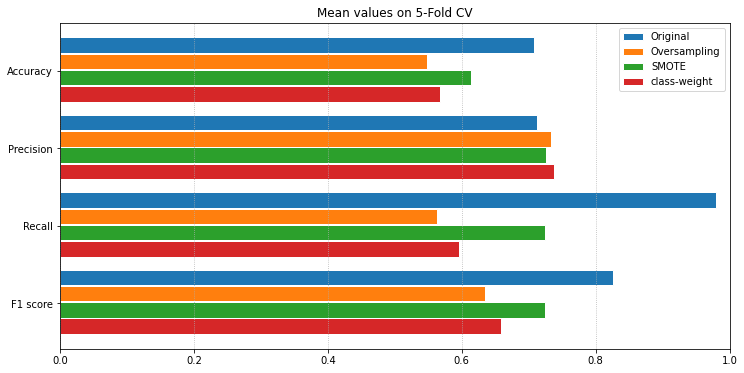

In [52]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.2
space=0.01
 
bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]
bars4 = [w_f1, w_rec, w_pre, w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight", height=barWidth, edgecolor='white', )

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

In [53]:
# area under the curve evaluation
def roc_area(tpr, fpr):
    area = 0
    for i in range(len(tpr)-1):
        base = fpr[i+1]-fpr[i]
        h = tpr[i]
        area += base*h
        
    return round(area, 3)

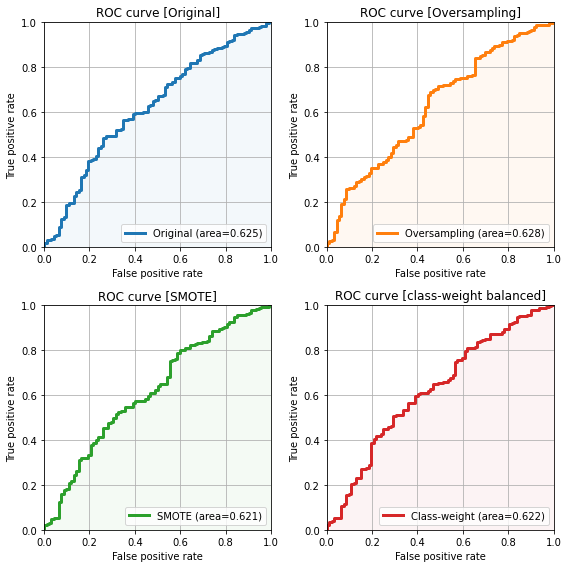

In [54]:
fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_sgc["credit_risk"], raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_sgc["credit_risk"], raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='tab:blue')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='tab:blue')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='tab:orange')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='tab:orange')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='tab:green')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='tab:green')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"Class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='tab:red')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='tab:red');

plt.tight_layout()

## K Nearest Neighbors  <a class="anchor" id="knn"></a> [△](#ix2)

KNN model classify new points according to the class of the nearest neighbors.
Nearest neighbors are evaluated according to a distance metric function and for each new point, only a fixed number of neighbors are taken into account.
This model is quite simple but it doesn't scale well, from computation point of view.
In fact, to predict a new point is necessary to store the entire dataset, so when the number of features or the number of records is very high, the computation could be heavy.
Considering the way KNN learns, it is possible to re-train an already trained model on new data.

The parameters taken into account are, of course, the number of neighbors but also the distance metric that is the <b>minkowski distance</b>:

$${\Big(\sum_{i=1}^{n}{|x_i-y_i|^p}\Big)^{1/p}}$$

in which the parameter $p$ is changed.
Then is also possible to weight the neighbors according to their distance from the new point: `weights="distance"`.

In [55]:
n_neigh = [1, 5, 10, 20, 50]
metric = "minkowski"
p = [2, 3, 4, 5]
h = 0.03

x_min, x_max = sgc_norm["age"].min() - .5, sgc_norm["age"].max() + .5
y_min, y_max = sgc_norm["amount"].min() - .5, sgc_norm["amount"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [56]:
print("Evaluting different number of nearest neighbors")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(n_neigh[i], weights="uniform", metric=metric, p=2)
    knn.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_selected)

    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="Bad", color=color_0, edgecolor='BLACK')
    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="God", color=color_1, edgecolor='BLACK')

    ax1.set_xlabel("age")
    ax1.set_ylabel("amount")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) n_neigh={n_neigh[i]}")
    
    # distance
    knn = KNeighborsClassifier(n_neigh[i], weights="distance", metric=metric, p=2)
    knn.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_selected)

    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="Bad", color=color_0, edgecolor='BLACK')
    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="Good", color=color_1, edgecolor='BLACK')

    ax2.set_xlabel("age")
    ax2.set_ylabel("amount")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) n_neigh={n_neigh[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(n_neigh),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Evaluting different number of nearest neighbors


In [57]:
print("Evaluating different values of p for minkowski distance metric")
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2);
%matplotlib inline 
plt.ion()

fig.set_size_inches(8, 4);
def animate_func(i):
    knn = KNeighborsClassifier(10, weights="uniform", metric=metric, p=p[i])
    knn.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_selected)

    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="Bad", color=color_0, edgecolor='BLACK')
    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="Good", color=color_1, edgecolor='BLACK')

    ax1.set_xlabel("age")
    ax1.set_ylabel("amount")
    ax1.legend();
    ax1.set_title(f"KNN (weights=uniform) p={p[i]}")
    
    # distance
    knn = KNeighborsClassifier(10, weights="distance", metric=metric, p=p[i])
    knn.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_selected)

    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="Bad", color=color_0, edgecolor='BLACK')
    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                    sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="Good", color=color_1, edgecolor='BLACK')

    ax2.set_xlabel("age")
    ax2.set_ylabel("amount")
    ax2.legend();
    ax2.set_title(f"KNN (weights=distance) p={p[i]}")
    
    fig.tight_layout()
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(p),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

Evaluating different values of p for minkowski distance metric


Now let's apply it on our training set considering all features

### `weights = "original"`

In [58]:
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1 = [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1 = [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1 = [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
       
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    rs_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    rs_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    rs_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    sm_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    sm_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    sm_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))
        
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    knn.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    no_rs_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    no_rs_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    no_rs_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))
    
#print(no_rs_acc[9], rs_acc[9], sm_acc[9])
#print(no_rs_f1[9], rs_f1[9], sm_f1[9])


In [59]:
# k fold
rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):
    
    #no oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)
    
    # oversampling
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)

    # SMOTE
    knn = KNeighborsClassifier(n, weights="uniform", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)
        
    

K-Fold cross-validation metrics (5 folds)


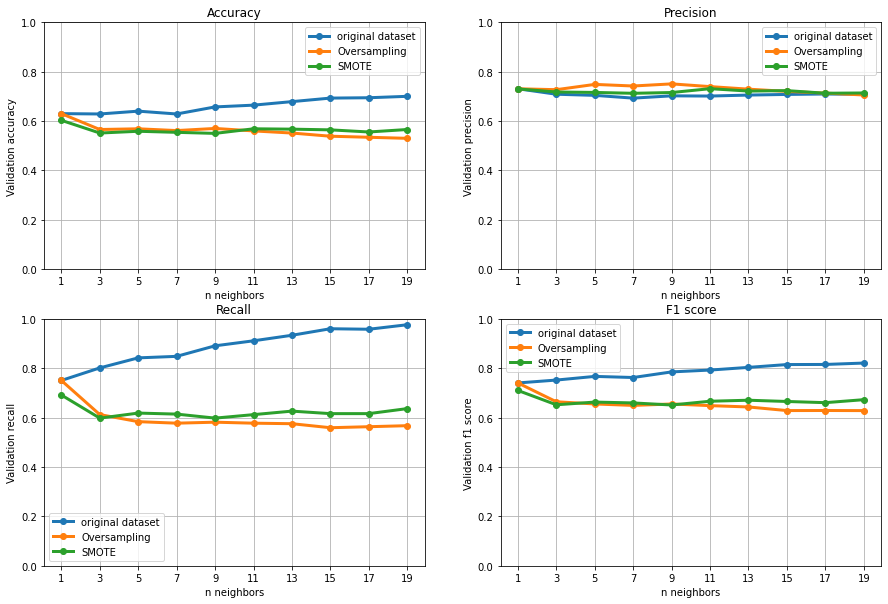

In [60]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(15, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)   
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3) 
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4)    
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

### `weights = "distance"`

In [61]:
n_neigh = range(1, 21, 2)
n = len(n_neigh)

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []
rs_raw_pred, sm_raw_pred, no_rs_raw_pred = [], [], []

for i,n in enumerate(n_neigh):
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    rs_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    rs_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    rs_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    rs_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))

    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    sm_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    sm_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    sm_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    sm_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    sm_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))
        
    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    knn.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk']);
    pred = knn.predict_proba(ho_val_sgc[all_features_selected]);
    pred=pred[:, 1]
    no_rs_raw_pred.append(pred.copy())
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
        
    no_rs_acc.append(accuracy_score(ho_val_sgc["credit_risk"], pred))
    no_rs_rec.append(recall_score(ho_val_sgc["credit_risk"], pred))
    no_rs_pre.append(precision_score(ho_val_sgc["credit_risk"], pred))
    no_rs_f1.append(f1_score(ho_val_sgc["credit_risk"], pred))

#print(no_rs_acc[9], rs_acc[9], sm_acc[9])
#print(no_rs_f1[9], rs_f1[9], sm_f1[9])


In [62]:
# k fold

rs_acc, rs_rec, rs_pre, rs_f1= [], [], [], []
sm_acc, sm_rec, sm_pre, sm_f1= [], [], [], []
no_rs_acc, no_rs_rec, no_rs_pre, no_rs_f1= [], [], [], []

for i,n in enumerate(n_neigh):

    # no oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling=None)
    no_rs_acc.append(acc)
    no_rs_rec.append(rec)
    no_rs_pre.append(pre)
    no_rs_f1.append(f1)
         
    # oversampling
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling="oversampling")
    rs_acc.append(acc)
    rs_rec.append(rec)
    rs_pre.append(pre)
    rs_f1.append(f1)
    
    # SMOTE
    knn = KNeighborsClassifier(n, weights="distance", metric=metric, p=2)
    acc, pre, rec, f1 = kfold.fit_predict(knn, ho_train_sgc, ho_train_sgc['credit_risk'],
                                          threshold=0.5, resampling="SMOTE", cached="True")
    sm_acc.append(acc)
    sm_rec.append(rec)
    sm_pre.append(pre)
    sm_f1.append(f1)  
   

K-Fold cross-validation metrics (5 folds)


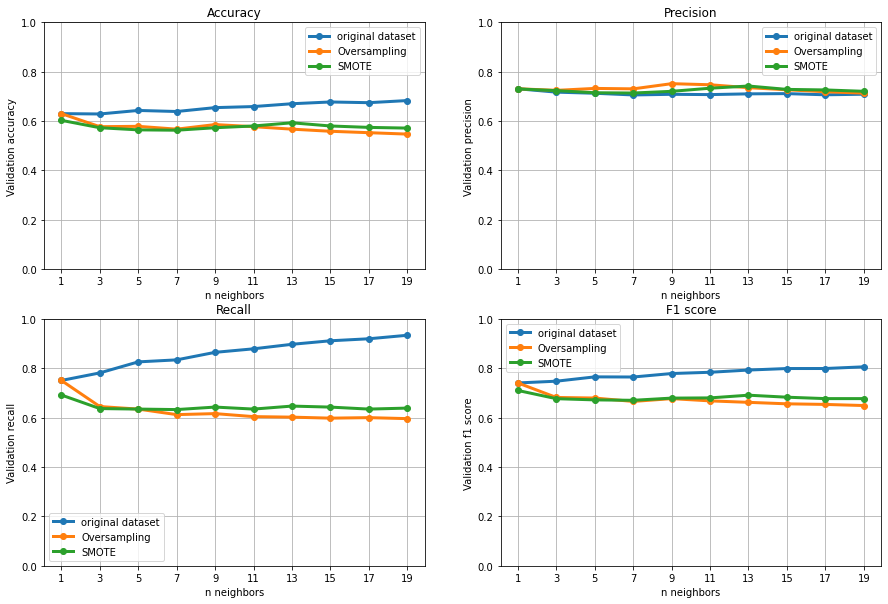

In [63]:
print("K-Fold cross-validation metrics (5 folds)")
plt.figure(figsize=(15, 10))

# accuracy
plt.subplot(2, 2, 1)    
plt.plot(list(n_neigh), no_rs_acc, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_acc, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_acc, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation accuracy")
plt.xlabel("n neighbors")
plt.title("Accuracy")

# precision
plt.subplot(2, 2, 2)   
plt.plot(list(n_neigh), no_rs_pre, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_pre, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_pre, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation precision")
plt.xlabel("n neighbors")
plt.title("Precision")

# recall
plt.subplot(2, 2, 3)    
plt.plot(list(n_neigh), no_rs_rec, label = "original dataset", marker='o', linewidth=3)
plt.plot(list(n_neigh), rs_rec, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_rec, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation recall")
plt.xlabel("n neighbors")
plt.title("Recall")

# f1 score
plt.subplot(2, 2, 4) 
plt.plot(list(n_neigh), no_rs_f1, label = "original dataset", marker='o', linewidth=3)  
plt.plot(list(n_neigh), rs_f1, label="Oversampling", marker='o', linewidth=3)
plt.plot(list(n_neigh), sm_f1, label="SMOTE", marker='o', linewidth=3)
plt.xticks(n_neigh)

plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.ylabel("Validation f1 score")
plt.xlabel("n neighbors")
plt.title("F1 score");

## Support Vector Machine <a class="anchor" id="svm"></a> [△](#ix2)

Support vector machine is a powerful model used for both classification and regression.
SVM consists in trying to fit an hyperplane that divides the dataset into the two classes by maximizing the <b>margin</b>, that is the distance between the hyperplane and the closest points.

<br><img style="float: center;" src="https://github.com/carmineds33/MathExam/blob/main/svm.png?raw=true" width="300" height="300"><br>

#### Hard margin

If data are linearly separable we can use the simplest implementation od SVM.<br>
Any hyperplane can be written as the set of points $\mathbf{x}$ satisfying

$${ \mathbf{w} ^{T}\mathbf{x} + b=0}$$

where $\mathbf{w}$  is the normal vector to the hyperplane.

We can select two parallel hyperplanes that separate the two classes of data, so geometrically, this distance is 

$$ \frac{2}{\left \| \mathbf{w} \right \|}$$

So we need to find $\mathbf{w}$ and $b$ such that distance is maximized (considering the whole training set) and at the same time all the points are classified correctly. But maximizing $ \frac{2}{\left \| \mathbf{w} \right \|}$ corresponds to minimizing $ \frac{\left \| \mathbf{w} \right \|}{2}$ or (for convenience with gradients) $ \frac{\left \| \mathbf{w} \right \|^2}{2}$.

So:

\begin{align} {\min_{\mathbf{w},b} \frac{1}{2}‖\mathbf{w}‖^2  \space\space s.t. \space\space \forall i,\space\space y_i \big(\mathbf{w} ^{T}\mathbf{x}_i + b\big)\ge 1} \end{align}

where $y_i$ is the true label and the prediction is the evaluated distance of the sample from the hyperplane. Basically if the label and the prediction have the same sign it means that the prediction is on the correct side of the margin.
When the algorithm has converged, then the model can be described using only the $\mathbf{x}_i$ points on the margin, called <b>support vectors</b>. This allows svm a good scalability.

Being able to respect this constraint means having a linearly separable problem.
The main drawback is that, in the real world, the vast majority of the problems are not linearly separable, and an algorithm like this one would not converge.
For this reason we can add a term on the constraints to relax them.

#### Soft margin

The relaxation of the constraints leads to the following optimization problem:

\begin{align} { \min_{\mathbf{w},b} \Big(\frac{1}{2} ‖\mathbf{w}‖^2 + {{C \sum_{i=1}^{m} {\xi_i}}}\Big) \space \space s.t. \space \space \forall i,\space\space y_i \big(\mathbf{w} ^{T}\mathbf{x}_i+b \big)≥ 1 {−\xi_i\space\space and \space\space \xi_i≥0} } \end{align}

$\xi_i$ is called <b>slack variable</b> and are commonly used in optimization to define relaxed versions of constraints. Here, a slack variable $\xi_i$ measures the distance by which vector $x_i$ violates the desired inequality, $y_i \big(\mathbf{w} ^{T}\mathbf{x}_i + b\big)\ge 1$.

<b>C</b> is a hypermeter to control error: smaller values of C allows more errors in exchange of a bigger margin, while higher values can be used where it's needed to be less permissive regarding misclassificatons, with an higher risk of overfitting.

#### Kernel trick

Kernel trick is a flexible technique that can be used to extend algorithms such as SVMs to define non-linear decision boundaries. The main idea is replacing the original inner product in the input space with positive definite kernels to obtain a linear separation in a high-dimensional space, that means a non-linear separation in the input space.

To solve the SVM optimization problem more efficiently the way is the <b>Lagrangian Dual Representation</b> and in particular is necessary to solve the inner product $\langle \textbf{x}, \textbf{x}^\prime\rangle$. Considering the mapping, this operation could be unfeasible.

A <b>kernel function</b> is a function that implements the inner product in the new feature space:

$${ K(\textbf{x},\textbf{x}^\prime) =\langleΦ(\textbf{x}),Φ(\textbf{x}^\prime)\rangle}$$

In this way we don't have to explicitly apply $Φ$ on our data and then compute the inner product.

A symmetric function $K: X\times X \rightarrow \rm I\!R$ can be a kernel function if and only if it respects the <b>Mercer theorem</b> that says that the <b>Gram matrix</b>, that is the matrix such that: ${G_{i,j} = K (\textbf{x}_i, \textbf{x}_j)}$ needs to be positive semidefinite.

A matrix is semidefinite if and only if:

${\textbf{x}^T G \textbf{x} > 0\space \space\forall \textbf{x}\in R^n \backslash 0}$
and the aigenvalues are non-negative.<br><br>

The most used kernels are:

- The polynomial kernel (degree $d$)
$${(\gamma\langle \textbf{x}, \textbf{x}^\prime \rangle + 1)^d }$$
- The radial basis function (gaussian kernel)
$${e^{-\gamma ‖\textbf{x} - \textbf{x}^\prime‖^2}}$$

(Linear kernel means that no mapping is done and the kernel is simply 
${\langle \textbf{x}, \textbf{x}^\prime\rangle}$)

To better see how soft margin svm works with different kernels, we can see the classification according to `age` and `amount`.
Then the same algorithm will be tested on all the 7 features of the original, oversampled and SMOTE dataset.


In [64]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [65]:
%matplotlib notebook
plt.ioff()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3);
%matplotlib inline 
plt.ion()

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
h = 0.03
x_min, x_max = sgc_norm["age"].min() - .5, sgc_norm["age"].max() + .5
y_min, y_max = sgc_norm["amount"].min() - .5, sgc_norm["amount"].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

fig.set_size_inches(11, 4);
def animate_func(i):  
    # linear
    svm = SVC(C=C[i], kernel='linear', random_state=42, class_weight='balanced', probability=True)
    svm.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    ax1.clear()
    ax1.contourf(xx, yy, Z, alpha=0.7, cmap=cmap_selected, antialiased=True)
    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="alive", color=color_0, edgecolor='BLACK')
    ax1.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="dead", color=color_1, edgecolor='BLACK')

    ax1.set_xlabel("age")
    ax1.set_ylabel("amount")
    ax1.legend();
    ax1.set_title(f"Linear (C={C[i]})")
    
    # poly
    svm = SVC(C=C[i], kernel='poly', random_state=42, gamma='auto', degree=3, class_weight='balanced', probability=True)
    svm.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    ax2.clear()
    ax2.contourf(xx, yy, Z, alpha=0.7, cmap=cmap_selected, antialiased=True)
    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="alive", color=color_0, edgecolor='BLACK')
    ax2.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="dead", color=color_1, edgecolor='BLACK')

    ax2.set_xlabel("age")
    ax2.set_ylabel("amount")
    ax2.legend();
    ax2.set_title(f"Polynomial (C={C[i]})")

    # rbf
    svm = SVC(C=C[i], kernel='rbf', random_state=42, gamma='auto', class_weight='balanced', probability=True)
    svm.fit(sgc_norm[["age", "amount"]], sgc_norm['credit_risk'])

    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    ax3.clear()
    ax3.contourf(xx, yy, Z, alpha=0.7, cmap=cmap_selected, antialiased=True)
    
    ax3.scatter(sgc_norm[sgc_norm["credit_risk"]==0]["age"],
                sgc_norm[sgc_norm["credit_risk"]==0]["amount"], label="alive", color=color_0, edgecolor='BLACK')
    ax3.scatter(sgc_norm[sgc_norm["credit_risk"]==1]["age"],
                sgc_norm[sgc_norm["credit_risk"]==1]["amount"], label="dead", color=color_1, edgecolor='BLACK')

    ax3.set_xlabel("age")
    ax3.set_ylabel("amount")
    ax3.legend();
    ax3.set_title(f"Radial Basis Function (C={C[i]})")
    
    fig.tight_layout()
    return [fig]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(C),
                               interval = 500, # in ms
                               );
HTML(anim.to_jshtml())

### Linear kernel <a class="anchor" id="svm-lk"></a> [△](#ix2)

In [66]:
C = 1

# original
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
lin_raw_pred_no_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

lin_no_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
lin_no_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
lin_no_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
lin_no_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# oversampled
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
lin_raw_pred_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

lin_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
lin_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
lin_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
lin_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# SMOTE
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
svm.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
lin_raw_pred_sm = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

lin_sm_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
lin_sm_rec = recall_score(ho_val_sgc["credit_risk"], pred)
lin_sm_pre = precision_score(ho_val_sgc["credit_risk"], pred)
lin_sm_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# class-weight balanced
svm = SVC(kernel="linear", random_state=42, probability=True, class_weight="balanced", C = C)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
lin_raw_pred_w = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

lin_w_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
lin_w_rec = recall_score(ho_val_sgc["credit_risk"], pred)
lin_w_pre = precision_score(ho_val_sgc["credit_risk"], pred)
lin_w_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

#print(lin_no_rs_acc, lin_rs_acc, lin_sm_acc, lin_w_acc)
#print(lin_no_rs_f1, lin_rs_f1, lin_sm_f1, lin_w_f1)


In [67]:
# original
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_no_rs_acc, lin_no_rs_pre, lin_no_rs_rec, lin_no_rs_f1 = kfold.fit_predict(svm, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5, resampling="oversampling")

# oversampled
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_rs_acc, lin_rs_pre, lin_rs_rec, lin_rs_f1 = kfold.fit_predict(svm, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5, resampling="SMOTE", cached=True)

# SMOTE
svm = SVC(kernel="linear", random_state=42, probability=True, C = C)
lin_sm_acc, lin_sm_pre, lin_sm_rec, lin_sm_f1 = kfold.fit_predict(svm, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5)

# class-weight balanced
svm = SVC(kernel="linear", random_state=42, probability=True, class_weight="balanced", C = C)
lin_w_acc, lin_w_pre, lin_w_rec, lin_w_f1 = kfold.fit_predict(svm, ho_train_sgc, ho_train_sgc['credit_risk'], threshold=0.5)

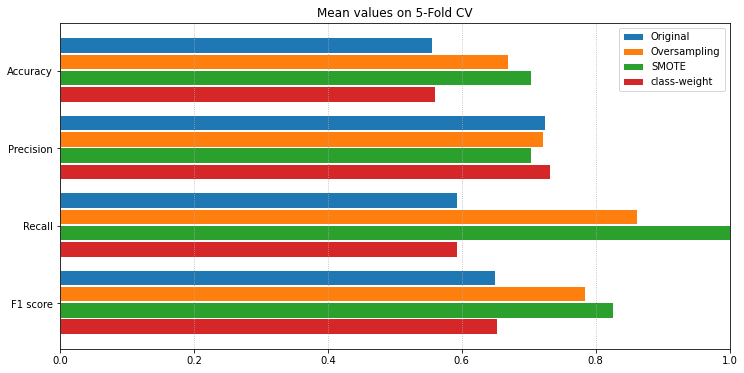

In [68]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.2
space=0.01
 
bars1 = [lin_no_rs_f1, lin_no_rs_rec, lin_no_rs_pre, lin_no_rs_acc]
bars2 = [lin_rs_f1, lin_rs_rec, lin_rs_pre, lin_rs_acc]
bars3 = [lin_sm_f1, lin_sm_rec, lin_sm_pre, lin_sm_acc]
bars4 = [lin_w_f1, lin_w_rec, lin_w_pre, lin_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original",height=barWidth, edgecolor='white')
plt.barh(r3, bars2, label="Oversampling", height=barWidth, edgecolor='white')
plt.barh(r2, bars3, label="SMOTE", height=barWidth, edgecolor='white')
plt.barh(r1, bars4, label="class-weight", height=barWidth, edgecolor='white')

plt.title("Mean values on 5-Fold CV")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend();

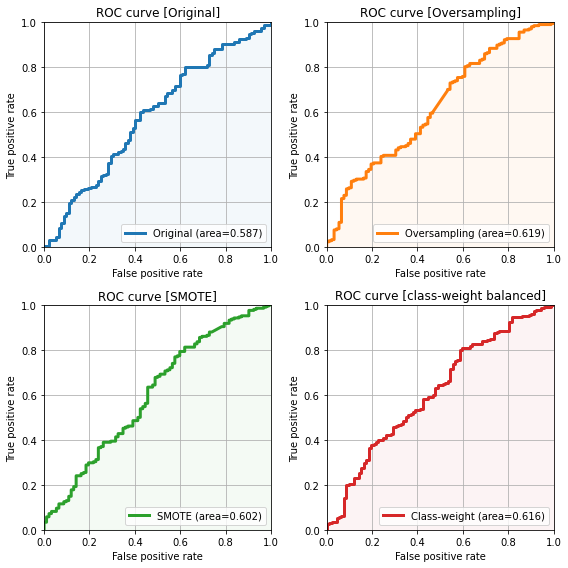

In [69]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], lin_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], lin_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_sgc["credit_risk"], lin_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_sgc["credit_risk"], lin_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='tab:blue')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='tab:blue')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='tab:orange')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='tab:orange')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='tab:green')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='tab:green')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"Class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='tab:red')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='tab:red');

plt.tight_layout()

### Gridsearch for hypermeters <a class="anchor" id="svm-gs"></a> [△](#ix2)

As seen the two important element to set for these kernels are <b>C</b> and <b>gamma</b>. In particular <b>gamma</b> is a hypermeter to control the curvature we want in a decision boundary. So we performe a gridsearch model selection with KFold crossvalidation.

In [70]:
def _make_combinations(lenghts, n, comb, combs):
    if len(lenghts)==n:
        combs.append(comb.copy())
    else:
        for i in range(lenghts[n]):
            combs = _make_combinations(lenghts, n+1, comb+[i], combs)
    return combs

def make_combinations(lenghts):
    combs = []
    combs = _make_combinations(lenghts, 0, [], combs)
    return combs

In [71]:
def gridsearch(model, train_set, train_lab, params, starting_conf, resampling = None):
    
    results = []
    lenghts = [len(params[l]) for l in params.keys()]
    combs = make_combinations(lenghts)
    n_params = len(params.keys())

    for comb in combs:
        conf = starting_conf.copy()
        for i, param in enumerate(params.keys()):
            conf[param]=params[param][comb[i]]
        
        m = model(**conf)
        
        acc, pre, rec, f1 = kfold.fit_predict(model=m, X = train_set, y = train_lab, resampling=resampling, cached=True)
        results.append([acc, f1, conf])
    return np.asarray(results)  

In [72]:
variable_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

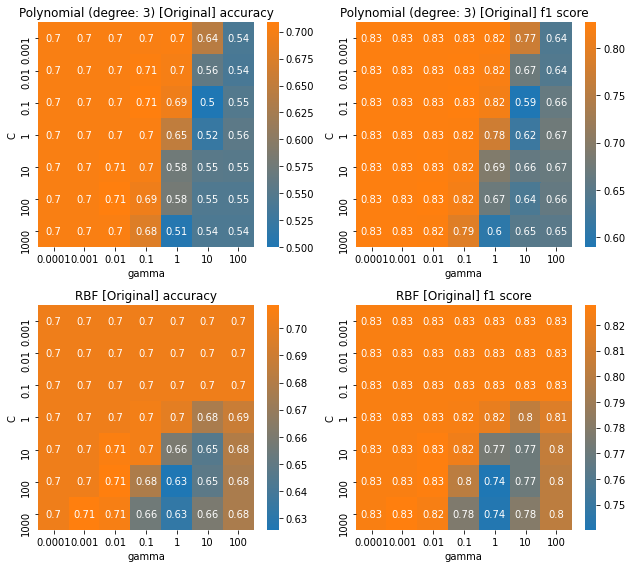

In [73]:
# Original dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params, starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Original] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Original] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params, starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Original] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Original] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

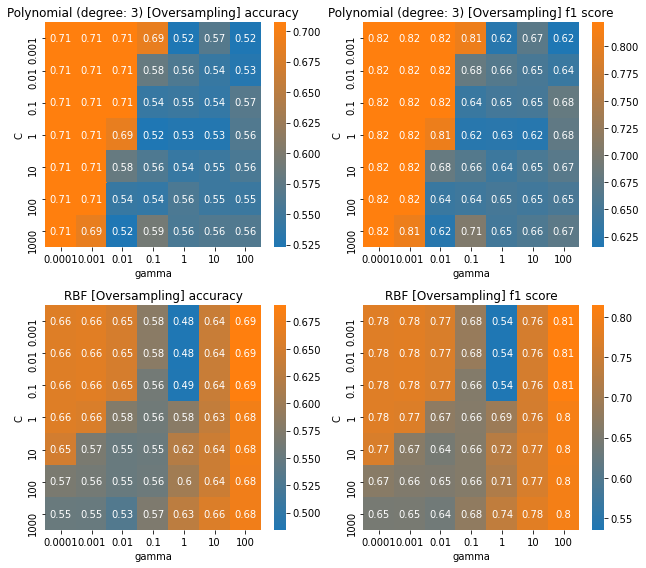

In [74]:
# random oversampling dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params, 
                     starting_params, resampling="oversampling")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Oversampling] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [Oversampling] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params,
                     starting_params, resampling="oversampling")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Oversampling] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [Oversampling] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

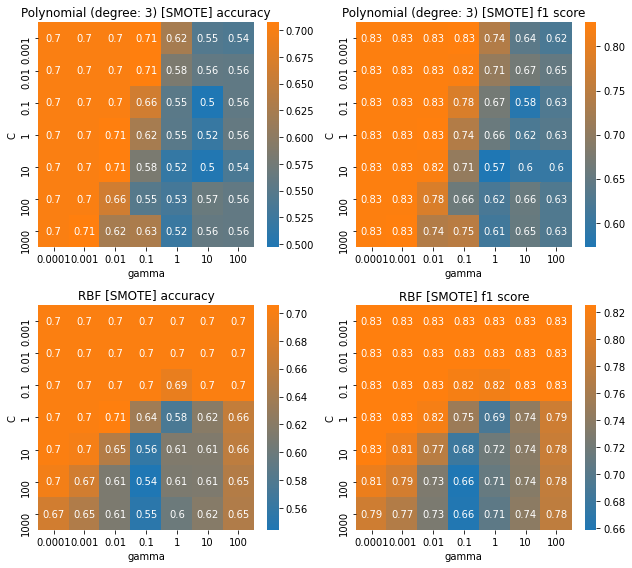

In [75]:
# SMOTE dataset
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}

results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params, 
                     starting_params, resampling="SMOTE")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [SMOTE] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3) [SMOTE] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":None, "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params,
                     starting_params, resampling="SMOTE")

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [SMOTE] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [SMOTE] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

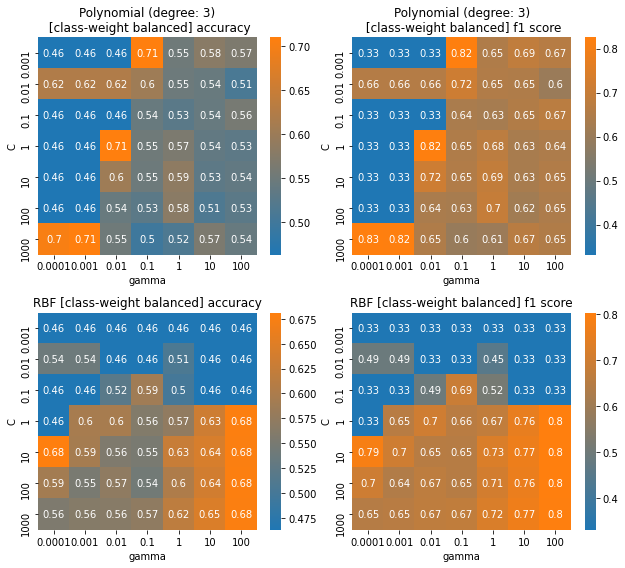

In [76]:
# class weight
plt.figure(figsize=(9, 8))

# poly 3 degree
plt.subplot(2, 2, 1)

starting_params = {"class_weight":"balanced", "random_state": 42, "kernel":"poly" , "degree": 3, 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params, 
                     starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3)\n [class-weight balanced] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

plt.subplot(2, 2, 2)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Polynomial (degree: 3)\n [class-weight balanced] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"])

# rbf
plt.subplot(2, 2, 3)

starting_params = {"class_weight":"balanced", "random_state": 42, "kernel":"rbf", 'max_iter':100000}
results = gridsearch(SVC, ho_train_sgc, ho_train_sgc['credit_risk'], variable_params,
                     starting_params)

matrix_res = results[:, 0].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap= cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [class-weight balanced] accuracy")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

plt.subplot(2, 2, 4)

matrix_res = results[:, 1].reshape(len(variable_params["C"]), len(variable_params["gamma"]))
matrix_res = matrix_res.astype(np.float64)

plt.tight_layout()
ax = sns.heatmap(matrix_res, annot=True, cmap=cmap_selected)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("RBF [class-weight balanced] f1 score")
ax.set_xticklabels(variable_params["gamma"])
ax.set_yticklabels(variable_params["C"]);

In [77]:
best_poly_no_rs = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":100, "gamma":0.01, "probability":True}
best_rbf_no_rs = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":100, "gamma":0.01, "probability":True}

best_poly_rs = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":1, "gamma":0.001, "probability":True}
best_rbf_rs = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":0.1, "gamma":100, "probability":True}

best_poly_sm = {"class_weight":None, "random_state": 42, "kernel":"poly" , "degree": 3, "C":1, "gamma":0.01, "probability":True}
best_rbf_sm = {"class_weight":None, "random_state": 42, "kernel":"rbf" , "C":1, "gamma":0.01, "probability":True}

best_poly_w = {"class_weight":"balanced", "random_state": 42, "kernel":"poly" , "degree": 3, "C":1000, "gamma":0.0001, "probability":True}
best_rbf_w = {"class_weight":"balanced", "random_state": 42, "kernel":"rbf" , "C":10, "gamma":100, "probability":True}

Best models are re-trained on the whole training set and then evaluated on the validation set.

### Polynomial kernel - best models <a class="anchor" id="svm-pk"></a> [△](#ix2)

In [78]:
# original
svm = SVC(**best_poly_no_rs)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
poly_raw_pred_no_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

poly_no_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
poly_no_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
poly_no_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
poly_no_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# oversampling
svm = SVC(**best_poly_rs)
svm.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
poly_raw_pred_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

poly_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
poly_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
poly_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
poly_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# SMOTE
svm = SVC(**best_poly_sm)
svm.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
poly_raw_pred_sm = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

poly_sm_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
poly_sm_rec = recall_score(ho_val_sgc["credit_risk"], pred)
poly_sm_pre = precision_score(ho_val_sgc["credit_risk"], pred)
poly_sm_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# class-weight balanced
svm = SVC(**best_poly_w)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
poly_raw_pred_w = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

poly_w_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
poly_w_rec = recall_score(ho_val_sgc["credit_risk"], pred)
poly_w_pre = precision_score(ho_val_sgc["credit_risk"], pred)
poly_w_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

#print(poly_no_rs_acc, poly_rs_acc, poly_sm_acc, poly_w_acc)
#print(poly_no_rs_f1, poly_rs_f1, poly_sm_f1, poly_w_f1)


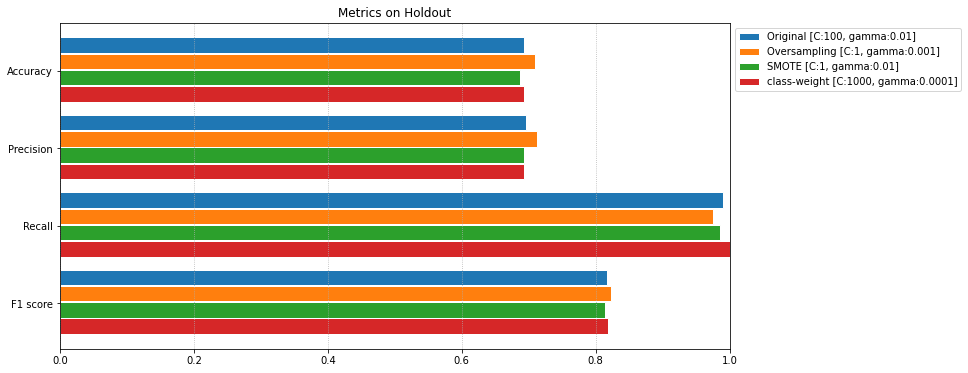

In [79]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.2
space=0.01
 
bars1 = [poly_no_rs_f1, poly_no_rs_rec, poly_no_rs_pre, poly_no_rs_acc]
bars2 = [poly_rs_f1, poly_rs_rec, poly_rs_pre, poly_rs_acc]
bars3 = [poly_sm_f1, poly_sm_rec, poly_sm_pre, poly_sm_acc]
bars4 = [poly_w_f1, poly_w_rec, poly_w_pre, poly_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original [C:100, gamma:0.01]",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling [C:1, gamma:0.001]", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE [C:1, gamma:0.01]", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight [C:1000, gamma:0.0001]", height=barWidth, edgecolor='white', )

plt.title("Metrics on Holdout")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy", ])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend(bbox_to_anchor=(1, 1));

#print(bars1)
#print(bars2)
#print(bars3)
#print(bars4)

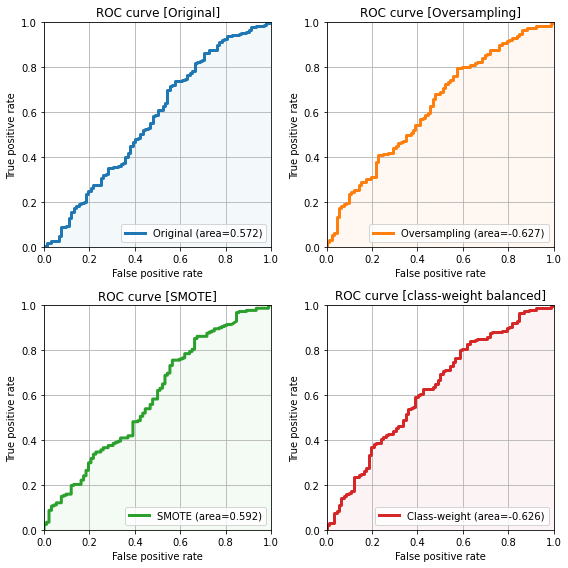

In [80]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], poly_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], poly_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_sgc["credit_risk"], poly_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_sgc["credit_risk"], poly_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='tab:blue')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='tab:blue')

plt.subplot(2, 2, 2)
plt.plot(1-fpr_rs, 1-tpr_rs, label=f"Oversampling (area={roc_area(1-tpr_rs, 1-fpr_rs)})", linewidth=3, color='tab:orange')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(1-fpr_rs, 0, 1-tpr_rs, alpha=0.05, color='tab:orange')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='tab:green')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='tab:green')

plt.subplot(2, 2, 4)
plt.plot(1-fpr_w, 1-tpr_w, label=f"Class-weight (area={roc_area(1-tpr_w, 1-fpr_w)})", linewidth=3, color='tab:red')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(1-fpr_w, 0, 1-tpr_w, alpha=0.05, color='tab:red');

plt.tight_layout()

### RBF kernel - best models <a class="anchor" id="svm-rbf"></a> [△](#ix2)

In [81]:
# original
svm = SVC(**best_rbf_no_rs)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
rbf_raw_pred_no_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

rbf_no_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
rbf_no_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
rbf_no_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
rbf_no_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# oversampling
svm = SVC(**best_rbf_rs)
svm.fit(ho_train_sgc_rs[all_features_selected], ho_train_sgc_rs['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
rbf_raw_pred_rs = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

rbf_rs_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
rbf_rs_rec = recall_score(ho_val_sgc["credit_risk"], pred)
rbf_rs_pre = precision_score(ho_val_sgc["credit_risk"], pred)
rbf_rs_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# SMOTE
svm = SVC(**best_rbf_sm)
svm.fit(ho_train_sgc_sm[all_features_selected], ho_train_sgc_sm['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
rbf_raw_pred_sm = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

rbf_sm_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
rbf_sm_rec = recall_score(ho_val_sgc["credit_risk"], pred)
rbf_sm_pre = precision_score(ho_val_sgc["credit_risk"], pred)
rbf_sm_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

# class-weight balanced
svm = SVC(**best_rbf_w)
svm.fit(ho_train_sgc[all_features_selected], ho_train_sgc['credit_risk'])

pred = svm.predict(ho_val_sgc[all_features_selected])
rbf_raw_pred_w = svm.predict_proba(ho_val_sgc[all_features_selected])[:, 1]

rbf_w_acc = accuracy_score(ho_val_sgc["credit_risk"], pred)
rbf_w_rec = recall_score(ho_val_sgc["credit_risk"], pred)
rbf_w_pre = precision_score(ho_val_sgc["credit_risk"], pred)
rbf_w_f1 = f1_score(ho_val_sgc["credit_risk"], pred)

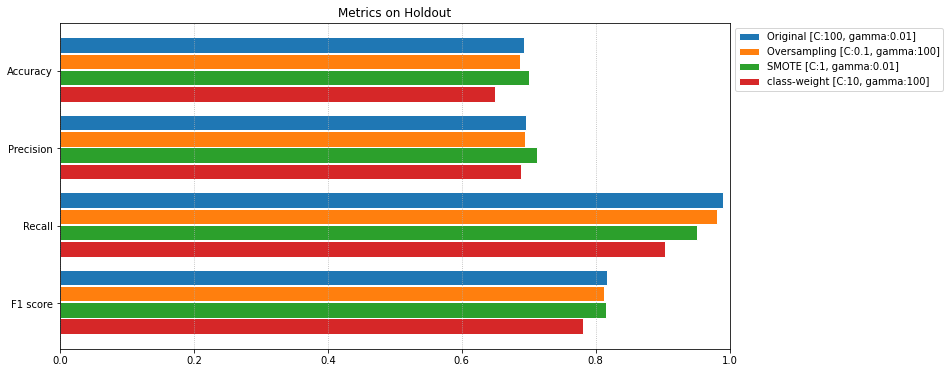

In [82]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.2
space=0.01

bars1 = [rbf_no_rs_f1, rbf_no_rs_rec, rbf_no_rs_pre, rbf_no_rs_acc]
bars2 = [rbf_rs_f1, rbf_rs_rec, rbf_rs_pre, rbf_rs_acc]
bars3 = [rbf_sm_f1, rbf_sm_rec, rbf_sm_pre, rbf_sm_acc]
bars4 = [rbf_w_f1, rbf_w_rec, rbf_w_pre, rbf_w_acc]

r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]
r4 = [x + barWidth + space for x in r3]

plt.barh(r4, bars1, label="Original [C:100, gamma:0.01]",height=barWidth, edgecolor='white', )
plt.barh(r3, bars2, label="Oversampling [C:0.1, gamma:100]", height=barWidth, edgecolor='white',)
plt.barh(r2, bars3, label="SMOTE [C:1, gamma:0.01]", height=barWidth, edgecolor='white', )
plt.barh(r1, bars4, label="class-weight [C:10, gamma:100]", height=barWidth, edgecolor='white', )

plt.title("Metrics on Holdout")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend(bbox_to_anchor=(1, 1));

#print(bars1)
#print(bars2)
#print(bars3)
#print(bars4)

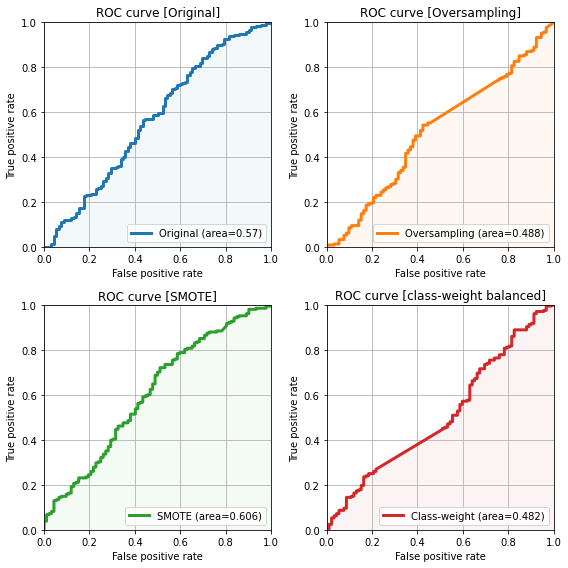

In [83]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], rbf_raw_pred_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], rbf_raw_pred_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_sgc["credit_risk"], rbf_raw_pred_sm)
fpr_w, tpr_w, thresholds = roc_curve(ho_val_sgc["credit_risk"], rbf_raw_pred_w)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='tab:blue')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='tab:blue')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='tab:orange')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='tab:orange')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='tab:green')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='tab:green')

plt.subplot(2, 2, 4)
plt.plot(fpr_w, tpr_w, label=f"Class-weight (area={roc_area(tpr_w, fpr_w)})", linewidth=3, color='tab:red')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [class-weight balanced]")
plt.fill_between(fpr_w, 0, tpr_w, alpha=0.05, color='tab:red');

plt.tight_layout()

## Naive Bayes <a class="anchor" id="nby"></a> [△](#ix2)

Naive bayes classifier is a probabilistic model based on the <b>Bayes theorem</b> in which is assumed a strong independence between the features.
The concept is that every feature independently contribute to the final prediction.
Our goal is to find:

\begin{align} {p(C=k|x_1, \dots, x_n)} \end{align}
<br>that is the probability of having the class k, given the sample features (considered independent).
Bayes theorem tells us that:

\begin{align} {p(C=k|X=x)=\frac{p(C=k)p(X=x|C=k)}{p(X=x)}} \end{align}
<br>We have to compute the feature distributions given the class $p(X=x|C=k)$, while $p(X=x)$ in this case is called <b>evidence</b> and is evaluated in this way: $p(X=x)=\sum_k p(C=k)p(X=x|C=k)$.
<br><br>$p(C=k)$ is the <b>prior</b>. This represents our prior knowledge on the class distribution. We will see that, changing the prior, the results may be very different.

Once the class probabilities given the sample are computed, one common strategy is to pick the most probable one:

\begin{align} {\hat{y} = argmax_{k \in {1, \dots, K}} \space p(C=k) \prod_{i=1}^{n}p(X_i=x_i|C=k)} \end{align}
where the evidence is ignored because is the same for every class.
Since we assume <b>feature independence</b>:

$${p(X=x|C=k})=\prod_{i=1}^{n}p(X_i=x_i| C=k)$$

To evaluate the probability of a sample given the class, it's important to know the feature distributions. This is a fundamental prior knowledge on features, picking the wrong distributions can leads to wrong results.

Before applying Naive Bayes we need to test that all the features are mutually independent, conditional on the target.
We already tested the linear independence of the features, now we can perform another check with the correlation matrix but considering the samples given the target label.

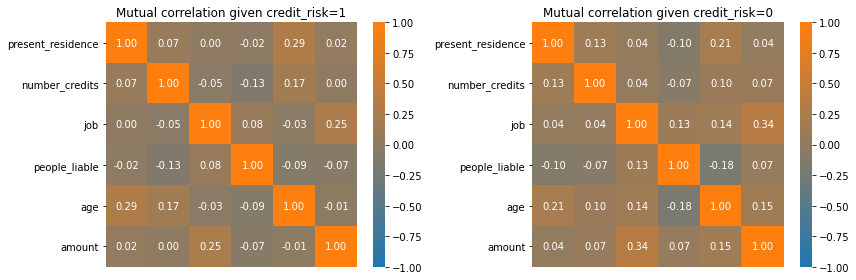

In [84]:
dead = sgc_norm[sgc_norm["credit_risk"]==1][all_features_selected].corr(method='pearson')
alive = sgc_norm[sgc_norm["credit_risk"]==0][all_features_selected].corr(method='pearson')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Mutual correlation given credit_risk=1")
sns.heatmap(dead, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap=cmap_selected, fmt='.2f')

plt.subplot(1, 2, 2)
plt.title("Mutual correlation given credit_risk=0")
sns.heatmap(alive, vmin=-1, vmax=1, annot=True, xticklabels=False, cmap= cmap_selected, fmt='.2f')

plt.tight_layout()

Speaking of the numerical features, it's interesting to notice whether or not they come from a normal distribution.
This is important because for <b>Gaussian Naive Bayes</b> classifier is assumed normality conditional to the class.
To test it, a <b>Shapiro-Wilk</b> test is performed on all numerical features.
The test statistic is:

\begin{align} { W = \frac {\Big( \sum_{i=1}^{n} a_i x_{(i)} \Big)^2} {\sum_{i=1}^{n} \big( x_i - \bar{x} \big)^2} } \end{align}

where $x_{(i)}$ is the i-th smallest number in the sample, $\bar{x}$ is the sample mean and $a_i$ are coefficients derived from a normal distributions.

The null hypothesis is that the samples are taken from a normal distribution, so with a sufficiently low value of the p-value we can consider the features as not normal.

In [85]:
from scipy.stats import shapiro

index = [(feat, "statistic") for feat in numerical_features_selected]
index.extend([(feat, "p-value") for feat in numerical_features_selected])

index = pd.MultiIndex.from_tuples(index)

sw_df = pd.DataFrame(index=index,  columns = ["All Classes", "0=Bad", "1=Good"])

for feat in numerical_features:
    x = sgc_norm[feat]
    stat, p = shapiro(x)
    
    sw_df["All Classes"].loc[(feat, "statistic")] = stat
    sw_df["All Classes"].loc[(feat, "p-value")] = p
    
    x = sgc_norm.loc[sgc["credit_risk"]==0, feat]
    stat, p = shapiro(x)
    sw_df["0=Bad"].loc[(feat, "statistic")] = stat
    sw_df["0=Bad"].loc[(feat, "p-value")] = p
    
    x = sgc_norm.loc[sgc["credit_risk"]==1, feat]
    stat, p = shapiro(x)
    sw_df["1=Good"].loc[(feat, "statistic")] = stat
    sw_df["1=Good"].loc[(feat, "p-value")] = p
    
sw_df = sw_df.unstack()

In [86]:
pd.set_option('display.float_format', '{:.3g}'.format)
sw_df

All Classes              0=Bad             1=Good          
           p-value statistic  p-value statistic  p-value statistic
age       6.93e-23     0.918 6.95e-14      0.89 4.47e-18     0.926
amount    8.62e-34     0.793 2.84e-18     0.814  5.2e-28     0.808

In this case, applying an hypotethical alpha value equal to 0.05, all the numerical features could be considered not normal.
This holds for the samples conditional on the class but also considering all of them, as we can see from the table.

### Mixed Naive Bayes <a class="anchor" id="mnb"></a> [△](#ix2)

Our dataset includes several categorical and few numerical features (which appear to have a non-normal distribution). It was decided to follow a mixed approach through the `mixed_naive_bayes` module [[4](#r4)]. This module implements categorical (<b>multinoulli</b>) and Gaussian naive Bayes algorithms.

Multinoulli distribution is the generalization of the Bernoulli distribution for a categorical random variable, i.e. for a discrete variable with more than two possible outcomes, such as the roll of a dice.

In particular with respect to the numerical features, one very nice positive aspect of Naive Bayes in general is the good performances even in cases in which some of the weak hypothesis are not respected.

In [ ]:
from mixed_naive_bayes import MixedNB
from sklearn.preprocessing import LabelEncoder

no_rs_acc, no_rs_pre, no_rs_rec, no_rs_f1= [], [], [], []
rs_acc, rs_pre, rs_rec, rs_f1= [], [], [], []
sm_acc, sm_pre, sm_rec, sm_f1= [], [], [], []

# no oversampling

V = np.array(ho_val_sgc[all_features_selected])
X = np.array(ho_train_sgc[all_features_selected])
y = np.array(ho_train_sgc['credit_risk'])
label_encoder = LabelEncoder()
for j in range(4):
    X[:,j] = label_encoder.fit_transform(X[:,j])
    V[:,j] = label_encoder.fit_transform(V[:,j])
nb = MixedNB(categorical_features=[0,1,2,3])
nb.fit(X, y)
pred = nb.predict(V)
mnb_raw_preds_no_rs = nb.predict_proba(V)[:, 1]

no_rs_acc=accuracy_score(ho_val_sgc['credit_risk'], pred)
no_rs_pre=precision_score(ho_val_sgc['credit_risk'], pred)
no_rs_rec=recall_score(ho_val_sgc['credit_risk'], pred)
no_rs_f1=f1_score(ho_val_sgc['credit_risk'], pred)

#oversampling

V = np.array(ho_val_sgc[all_features_selected])
X = np.array(ho_train_sgc_rs[all_features_selected])
y = np.array(ho_train_sgc_rs['credit_risk'])
label_encoder = LabelEncoder()
for j in range(4):
    X[:,j] = label_encoder.fit_transform(X[:,j])
    V[:,j] = label_encoder.fit_transform(V[:,j])
nb = MixedNB(categorical_features=[0,1,2,3])
nb.fit(X, y)
pred = nb.predict(V)
mnb_raw_preds_rs = nb.predict_proba(V)[:, 1]

rs_acc=accuracy_score(ho_val_sgc['credit_risk'], pred)
rs_pre=precision_score(ho_val_sgc['credit_risk'], pred)
rs_rec=recall_score(ho_val_sgc['credit_risk'], pred)
rs_f1=f1_score(ho_val_sgc['credit_risk'], pred)

#SMOTE
        
V = np.array(ho_val_sgc[all_features_selected])
X = np.array(ho_train_sgc_sm[all_features_selected])
y = np.array(ho_train_sgc_sm['credit_risk'].astype('int64'))
label_encoder = LabelEncoder()
for j in range(4):
    X[:,j] = label_encoder.fit_transform(X[:,j])
    V[:,j] = label_encoder.fit_transform(V[:,j])
nb = MixedNB(categorical_features=[0,1,2,3])
nb.fit(X, y)
pred = nb.predict(V)
mnb_raw_preds_sm = nb.predict_proba(V)[:, 1]

sm_acc=accuracy_score(ho_val_sgc['credit_risk'], pred)
sm_pre=precision_score(ho_val_sgc['credit_risk'], pred)
sm_rec=recall_score(ho_val_sgc['credit_risk'], pred)
sm_f1=f1_score(ho_val_sgc['credit_risk'], pred)    



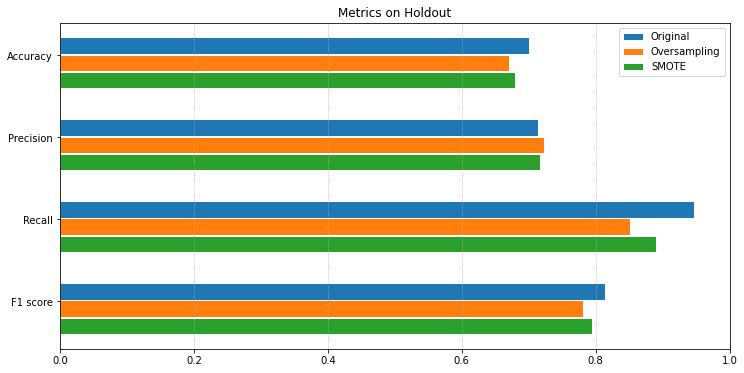

In [88]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.2
space=0.01

bars1 = [no_rs_f1, no_rs_rec, no_rs_pre, no_rs_acc]
bars2 = [rs_f1, rs_rec, rs_pre, rs_acc]
bars3 = [sm_f1, sm_rec, sm_pre, sm_acc]


r1 = np.arange(len(bars1))
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space for x in r2]

plt.barh(r3, bars1, label="Original",height=barWidth, edgecolor='white', )
plt.barh(r2, bars2, label="Oversampling", height=barWidth, edgecolor='white',)
plt.barh(r1, bars3, label="SMOTE", height=barWidth, edgecolor='white', )

plt.title("Metrics on Holdout")
plt.yticks([r + barWidth*1.5 for r in range(len(bars1))], ["F1 score", "Recall", "Precision", "Accuracy"])
plt.xlim(0, 1)
plt.gca().xaxis.grid(True, linestyle=':')
plt.legend(bbox_to_anchor=(1, 1));

#print(bars1)
#print(bars2)
#print(bars3)

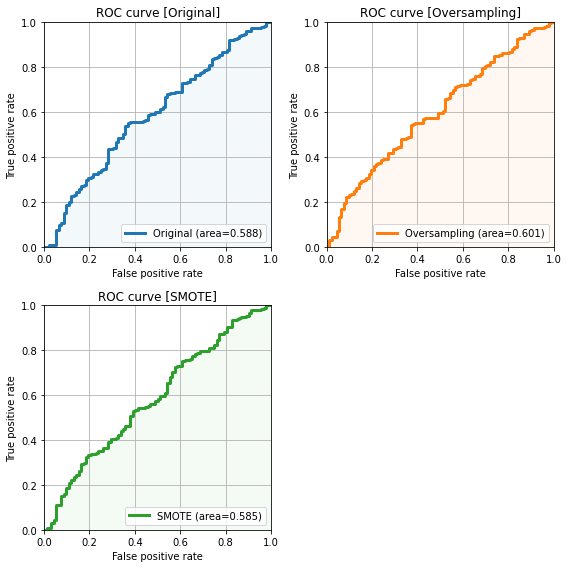

In [89]:
from sklearn.metrics import roc_curve

fpr_rs, tpr_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], mnb_raw_preds_rs)
fpr_no_rs, tpr_no_rs, thresholds = roc_curve(ho_val_sgc["credit_risk"], mnb_raw_preds_no_rs)
fpr_sm, tpr_sm, thresholds = roc_curve(ho_val_sgc["credit_risk"], mnb_raw_preds_sm)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr_no_rs, tpr_no_rs, label=f"Original (area={roc_area(tpr_no_rs, fpr_no_rs)})", linewidth=3, color='tab:blue')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Original]")
plt.fill_between(fpr_no_rs, 0, tpr_no_rs, alpha=0.05, color='tab:blue')

plt.subplot(2, 2, 2)
plt.plot(fpr_rs, tpr_rs, label=f"Oversampling (area={roc_area(tpr_rs, fpr_rs)})", linewidth=3, color='tab:orange')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [Oversampling]")
plt.fill_between(fpr_rs, 0, tpr_rs, alpha=0.05, color='tab:orange')

plt.subplot(2, 2, 3)
plt.plot(fpr_sm, tpr_sm, label=f"SMOTE (area={roc_area(tpr_sm, fpr_sm)})", linewidth=3, color='tab:green')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve [SMOTE]")
plt.fill_between(fpr_sm, 0, tpr_sm, alpha=0.05, color='tab:green')


plt.tight_layout()

In [189]:
t = np.where(ho_val_sgc['credit_risk']==1)
flat_list = [item for sublist in t for item in sublist]
len(flat_list)

208

# Conclusions <a class="anchor" id="con"></a> [△](#ix2)

These are the results obtained with different models and different rebalancing techniques on <b>Holdout</b> sets. 
<br>Accuracy and f1 score (inside parenthesis) are showed.

| Model | Original | Oversampling | SMOTE | class-weight |
|:---|---:|---:|---:|---:|
| Decision Tree | 0.613 <br> [0.734] | 0.588 <br> [0.687] | 0.602 <br> [0.706] | 0.600 <br> [0.696] |
| Random Forest (100T) | 0.684 <br> [0.800] | 0.620 <br> [0.726] | 0.616 <br> [0.733] | 0.655 <br> [0.763] |
| Logistic Regression | 0.696 <br> [0.817] | 0.600 <br> [0.680] | 0.676 <br> [0.773] | 0.603 <br> [0.695] |
| KNN original | 0.683 <br> [0.809] | 0.593 <br> [0.675] | 0.626 <br> [0.714] | - |
| KNN distance | 0.683 <br> [0.800] | 0.576 <br> [0.663] | 0.583 <br> [0.677] | - |
| Linear SVM | 0.693 <br> [0.818] | 0.586 <br> [0.677] | 0.703 <br> [0.814] | 0.600 <br> [0.690] |
| Poly SVM | 0.693 <br> [0.817] | <b>0.710</b> <br> <b>[0.823]</b> | 0.686 <br> [0.813] | 0.693 <br> [0.818] |
| RBF SVM | 0.693 <br> [0.817] | 0.686 <br> [0.812] | 0.700 <br> [0.814] | 0.650 <br> [0.781] |
| Mixed Naive Bayes | 0.700 <br> [0.814] | 0.670 <br> [0.781] | 0.680 <br> [0.793] | - |

As you can see, the general results are very similar. 

Decision Tree has low performance as imaginable due to the extreme simplicity of the single tree model. There is a noticeable improvement with a Random Forest of 100 trees.

Logistic Regression also performs well on the original dataset, it seems to suffer from resampling techniques.

KNN seems not to be the best choice probably due to the numerous categorical features considered (between different categories, even if mapped numerically, the concept of distance loses sense).

SVM seems to be a great way. In particular, the use of kernels in combination with resampling techniques gives the best results.

Mixed-bayes model also seems to be in line with the other results especially with original dataset (even if the hypotheses are not fully respected).

Finally, we add a consideration on the other calculated metrics: the classifiers tested under the described balancing conditions appear to be on average very efficient in recognizing the "good opportunities" of credit (high Recall). However, they do not always manage to avoid admitting "bad opportunities" of credit (Precision around 0.7).

# References  <a class="anchor" id="ref"></a> [△](#ix2)

 <a class="anchor" id="r1">[1]</a> Häußler, W.M. (1979, in German). Empirische Ergebnisse zu Diskriminationsverfahren bei Kreditscoringsystemen. *Zeitschrift für Operations Research* 23, B191-B210<br>

<a class="anchor" id="r2">[2]</a> Fahrmeir, L. and Hamerle, A. (1981, in German). Kategoriale Regression in der betrieblichen Planung. *Zeitschrift für Operations Research* 25, B63-B78<br>

<a class="anchor" id="r3">[3]</a> N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer. SMOTE: Synthetic Minority Over-sampling Technique, 2002<br>

<a class="anchor" id="r4">[4]</a> remykarem, mixed-naive-bayes, GitHub 

In [90]:
from IPython.core.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')